In [1]:
import DirectDmTargets as dddm

calculating effective efficancy for Xe detector done
calculating effective efficancy for Ar detector done
calculating effective efficancy for Ge detector done


In [2]:
import wimprates as wr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

In [7]:
import pandas as pd

In [8]:
import scipy

In [9]:
import emcee
emcee.__version__

'3.0.0'

In [10]:
import corner

In [11]:
import multiprocessing

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

# Emcee #
<https://emcee.readthedocs.io/en/stable/tutorials/quickstart/>

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [12]:
use_SHM = dddm.SHM()
xe_events = dddm.GenSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
xe_data = xe_events.get_data(poisson = True)
xe_data

,counts,bin_centers,bin_left,bin_right
0,4460.0,5.0,0.0,10.0
1,1742.0,15.0,10.0,20.0
2,602.0,25.0,20.0,30.0
3,222.0,35.0,30.0,40.0
4,62.0,45.0,40.0,50.0
5,14.0,55.0,50.0,60.0
6,4.0,65.0,60.0,70.0
7,0.0,75.0,70.0,80.0
8,1.0,85.0,80.0,90.0
9,0.0,95.0,90.0,100.0


In [13]:
# priors = {
#     'log_mass':         {'range':[0.1,3],    'prior_type':'flat'},
#     'log_cross_secion': {'range':[-10, -6],    'prior_type':'flat'}, 
#     'density':          {'range':[0.001, 0.9], 'prior_type':'gauss', 'mean':0.4, 'std':0.1} ,
#     'v_0':              {'range':[80, 380],    'prior_type':'gauss', 'mean':230, 'std':30}, 
#     'v_esc':            {'range':[379, 709],   'prior_type':'gauss', 'mean':544, 'std':33}, 
#     'k':                {'range':[0.5, 3.5],   'prior_type':'flat'} 
# }

# for key in priors.keys():
#     param = priors[key]
#     if param['prior_type'] == 'flat':
#         param['param'] = param['range']
#         param['dist'] = lambda x: flat_prior(x)
#     elif param['prior_type'] == 'gauss':
#         param['param'] = param['mean'], param['std']
#         param['dist'] = lambda x: gaus_prior(x)
    

In [14]:
# pos = 50 + np.random.randn(32, 1)
# nwalkers, ndim = pos.shape

# sampler = emcee.EnsembleSampler(nwalkers, ndim, 
#                 dddm.log_probability, args=(xe_data['bin_centers'],
#                                                             xe_data['counts'],
#                                                            'log_mass'))
# sampler.run_mcmc(pos, 50, progress=True);

In [15]:
# fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [16]:
# fig = corner.corner(flat_samples, labels=labels, truths=[50, 1e-45]);

In [17]:
# priors = {'log_cross_secion': {'range': [-46, -42], 'prior_type': 'flat'}}
# for key in priors.keys():
#     param = priors[key]
#     if param['prior_type'] == 'flat':
#         param['param'] = param['range']
#         param['dist'] = lambda x: flat_prior(x)
#     elif param['prior_type'] == 'gauss':
#         param['param'] = param['mean'], param['std']
#         param['dist'] = lambda x: gaus_prior(x)

In [18]:
# def log_flat(x, x_name):
#     a, b = priors[x_name]['param']
#     try:
#         if a < x < b:
#             return 0
#         else:
#             return -np.inf
#     except ValueError:
#         result = np.zeros(len(x))
#         mask = (x > a) & (x < b)
#         result[~mask] = -np.inf
#         return result

In [19]:
# def log_prior(x, x_name):
#     if priors[x_name]['prior_type'] == 'flat':
#         if 'log' in x_name:
#             return log_flat(np.log10(x), x_name)
#         else:
#             return log_flat(x, x_name)
#     elif priors[x_name]['prior_type'] == 'gauss':
#         return log_gauss(x, x_name)
#     else:
#         raise TypeError(f"unknown prior type '{priors[x_name]['prior_type']}', choose either gauss or flat")

In [20]:
xe_events = dddm.GenSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
xe_data = xe_events.get_data(poisson = False)

In [21]:
%%time
nwalkers = 100
steps   = 250
pos = np.hstack(
    [50 + np.random.randn(nwalkers, 1) ,
    1e-45 + 1e-45 * np.random.randn(nwalkers, 1)])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                dddm.log_probability, args=(xe_data['bin_centers'],
                                                            xe_data['counts'],
                                                           ['log_mass', 
                                                            'log_cross_section']), 
                               threads=multiprocessing.cpu_count())
sampler.run_mcmc(np.abs(pos), steps, progress=True);

C:\Users\Joran\Anaconda3\envs\DD_DM\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  0%|                                                                                       | 0/250 [00:00<?, ?it/s]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


C:\Users\Joran\Anaconda3\envs\DD_DM\lib\site-packages\emcee\moves\red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  0%|▎                                                                              | 1/250 [00:01<04:49,  1.16s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  1%|▋                                                                              | 2/250 [00:02<04:44,  1.15s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  1%|▉                                                                              | 3/250 [00:03<04:41,  1.14s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  2%|█▎                                                                             | 4/250 [00:04<04:44,  1.15s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  2%|█▌                                                                             | 5/250 [00:05<04:46,  1.17s/it]

finding a negative value for log_cross_section, returning -np.inf


  2%|█▉                                                                             | 6/250 [00:07<04:49,  1.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  3%|██▏                                                                            | 7/250 [00:08<04:53,  1.21s/it]

finding a negative value for log_cross_section, returning -np.inf


  3%|██▌                                                                            | 8/250 [00:09<04:46,  1.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  4%|██▊                                                                            | 9/250 [00:10<04:40,  1.16s/it]

finding a negative value for log_cross_section, returning -np.inf


  6%|████▎                                                                         | 14/250 [00:16<04:29,  1.14s/it]

finding a negative value for log_cross_section, returning -np.inf


100%|█████████████████████████████████████████████████████████████████████████████| 250/250 [04:51<00:00,  1.17s/it]


Wall time: 4min 52s


State([[4.88045661e+01 9.54857864e-46]
 [5.53775004e+01 1.07842040e-45]
 [5.19610499e+01 1.00685700e-45]
 [4.77646623e+01 1.02898109e-45]
 [4.95662880e+01 1.01315970e-45]
 [5.31247344e+01 1.05123984e-45]
 [4.81844572e+01 1.00843721e-45]
 [5.65911778e+01 9.53197741e-46]
 [5.01964659e+01 1.06817686e-45]
 [5.01390590e+01 9.95076159e-46]
 [4.95638294e+01 9.51431360e-46]
 [4.66814861e+01 9.92844984e-46]
 [5.20796721e+01 1.00188322e-45]
 [4.87521233e+01 9.42488440e-46]
 [4.78850701e+01 9.66845101e-46]
 [5.18218949e+01 1.01880750e-45]
 [4.66628368e+01 9.91174223e-46]
 [4.47177755e+01 9.98921988e-46]
 [5.13089764e+01 1.06504978e-45]
 [5.09743523e+01 9.70212690e-46]
 [5.54931827e+01 1.01050836e-45]
 [4.65679155e+01 9.44862731e-46]
 [4.96169600e+01 1.01700870e-45]
 [5.15086692e+01 1.02644675e-45]
 [5.16286318e+01 9.92491091e-46]
 [4.83268337e+01 9.81224027e-46]
 [4.85646805e+01 9.53352987e-46]
 [4.59183268e+01 9.42554516e-46]
 [4.86649670e+01 9.53994726e-46]
 [4.68464553e+01 9.71239425e-46]
 [5.

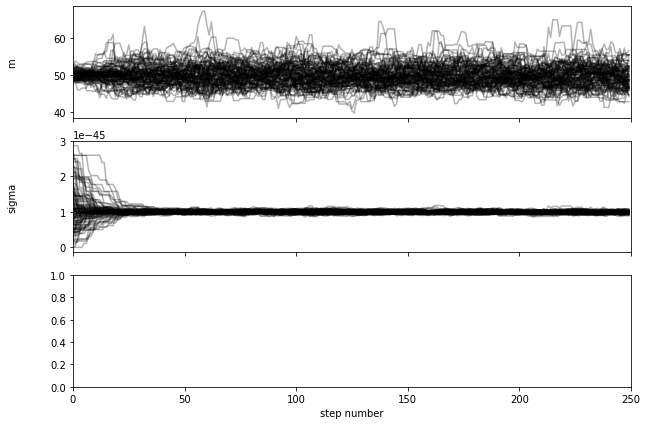

In [22]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "sigma", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
# fig = corner.corner(flat_samples, labels=labels, truths=[50, 1e-45]);

In [24]:
# tau = sampler.get_autocorr_time()
# print(tau)

In [25]:
flat_samples = sampler.get_chain(discard=int(steps*0.2), thin=15, flat=True)
print(flat_samples.shape)

(1300, 2)


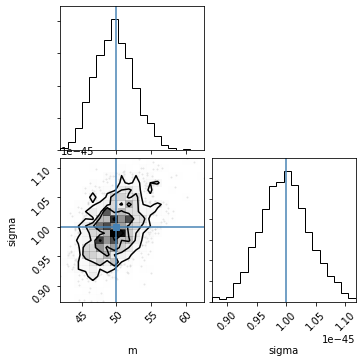

In [26]:
fig = corner.corner(flat_samples, labels=labels, truths=[50, 1e-45]);

In [27]:
# samples[:, 2] = np.exp(samples[:, 2])
# m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                              zip(*np.percentile(samples, [16, 50, 84],
#                                                 axis=0)))

In [28]:
nwalkers = 500
step = 1000
pos = np.hstack(
    [50   + 3*10 * np.random.rand(nwalkers, 1) ,
    1e-45 + 1e-45 * np.random.rand(nwalkers, 1),
    230   + 3*30 * np.random.rand(nwalkers, 1),
    544   + 3*33 * np.random.rand(nwalkers, 1),
    0.4   + 3*0.1 * np.random.rand(nwalkers, 1)   
    ])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                dddm.log_probability, args=(xe_data['bin_centers'],
                                                            xe_data['counts'],
                                                           ['log_mass',
                                                            'log_cross_section', 
                                                            'v_0',
                                                            'v_esc', 
                                                            'density']))
sampler.run_mcmc(np.abs(pos), step, progress=True);

  0%|                                                                            | 1/1000 [00:07<1:56:36,  7.00s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


  0%|▏                                                                           | 2/1000 [00:13<1:54:55,  6.91s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


  0%|▏                                                                           | 3/1000 [00:20<1:55:08,  6.93s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


  0%|▎                                                                           | 4/1000 [00:27<1:54:11,  6.88s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

  0%|▍                                                                           | 5/1000 [00:34<1:53:07,  6.82s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_esc, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, 

  1%|▍                                                                           | 6/1000 [00:40<1:52:40,  6.80s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


  1%|▌                                                                           | 7/1000 [00:47<1:51:04,  6.71s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

  1%|▌                                                                           | 8/1000 [00:53<1:49:06,  6.60s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

  1%|▋                                                                           | 9/1000 [01:00<1:48:25,  6.56s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

  1%|▊                                                                          | 10/1000 [01:06<1:47:17,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_se

  1%|▊                                                                          | 11/1000 [01:13<1:46:59,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

  1%|▉                                                                          | 12/1000 [01:19<1:46:42,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a ne

  1%|▉                                                                          | 13/1000 [01:25<1:45:11,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative

  1%|█                                                                          | 14/1000 [01:31<1:44:28,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

  2%|█▏                                                                         | 15/1000 [01:38<1:44:04,  6.34s/it]

finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_c

  2%|█▏                                                                         | 16/1000 [01:44<1:43:45,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

  2%|█▎                                                                         | 17/1000 [01:51<1:44:47,  6.40s/it]

finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for den

  2%|█▎                                                                         | 18/1000 [01:57<1:46:06,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

  2%|█▍                                                                         | 19/1000 [02:04<1:45:11,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cros

  2%|█▌                                                                         | 20/1000 [02:10<1:45:27,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for

  2%|█▌                                                                         | 21/1000 [02:16<1:43:29,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

  2%|█▋                                                                         | 22/1000 [02:23<1:44:09,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for

  2%|█▋                                                                         | 23/1000 [02:29<1:44:31,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative

  2%|█▊                                                                         | 24/1000 [02:35<1:42:34,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

  2%|█▉                                                                         | 25/1000 [02:42<1:43:08,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding

  3%|█▉                                                                         | 26/1000 [02:48<1:43:02,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

  3%|██                                                                         | 27/1000 [02:54<1:42:24,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross

  3%|██                                                                         | 28/1000 [03:01<1:42:46,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative va

  3%|██▏                                                                        | 29/1000 [03:07<1:42:25,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for lo

  3%|██▎                                                                        | 30/1000 [03:13<1:41:58,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

  3%|██▎                                                                        | 31/1000 [03:20<1:45:09,  6.51s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

  3%|██▍                                                                        | 32/1000 [03:27<1:45:48,  6.56s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_sec

  3%|██▍                                                                        | 33/1000 [03:34<1:46:27,  6.61s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning 

  3%|██▌                                                                        | 34/1000 [03:41<1:48:13,  6.72s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.in

  4%|██▋                                                                        | 35/1000 [03:47<1:47:43,  6.70s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

  4%|██▋                                                                        | 36/1000 [03:54<1:47:31,  6.69s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

  4%|██▊                                                                        | 37/1000 [04:00<1:46:05,  6.61s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

  4%|██▊                                                                        | 38/1000 [04:06<1:43:51,  6.48s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

  4%|██▉                                                                        | 39/1000 [04:13<1:41:53,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, 

  4%|███                                                                        | 40/1000 [04:19<1:40:58,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

  4%|███                                                                        | 41/1000 [04:25<1:39:50,  6.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.in

  4%|███▏                                                                       | 42/1000 [04:31<1:40:45,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

  4%|███▏                                                                       | 43/1000 [04:38<1:40:06,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

  4%|███▎                                                                       | 44/1000 [04:43<1:38:25,  6.18s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

  4%|███▍                                                                       | 45/1000 [04:50<1:39:38,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for

  5%|███▍                                                                       | 46/1000 [04:56<1:38:45,  6.21s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

  5%|███▌                                                                       | 47/1000 [05:02<1:38:09,  6.18s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

  5%|███▌                                                                       | 48/1000 [05:08<1:38:02,  6.18s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

  5%|███▋                                                                       | 49/1000 [05:15<1:39:06,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding 

  5%|███▊                                                                       | 50/1000 [05:21<1:39:12,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

  5%|███▊                                                                       | 51/1000 [05:27<1:39:05,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

  5%|███▉                                                                       | 52/1000 [05:34<1:38:59,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

  5%|███▉                                                                       | 53/1000 [05:40<1:38:16,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

  5%|████                                                                       | 54/1000 [05:46<1:38:00,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, return

  6%|████▏                                                                      | 55/1000 [05:52<1:38:09,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

  6%|████▏                                                                      | 56/1000 [05:58<1:37:13,  6.18s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

  6%|████▎                                                                      | 57/1000 [06:04<1:37:15,  6.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

  6%|████▎                                                                      | 58/1000 [06:11<1:37:04,  6.18s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

  6%|████▍                                                                      | 59/1000 [06:17<1:37:26,  6.21s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

  6%|████▌                                                                      | 60/1000 [06:23<1:37:29,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding 

  6%|████▌                                                                      | 61/1000 [06:29<1:37:56,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

  6%|████▋                                                                      | 62/1000 [06:36<1:38:23,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

  6%|████▋                                                                      | 63/1000 [06:42<1:38:00,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value fo

  6%|████▊                                                                      | 64/1000 [06:48<1:37:58,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for

  6%|████▉                                                                      | 65/1000 [06:55<1:37:27,  6.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a ne

  7%|████▉                                                                      | 66/1000 [07:01<1:38:33,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, re

  7%|█████                                                                      | 67/1000 [07:08<1:39:03,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

  7%|█████                                                                      | 68/1000 [07:14<1:37:42,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

  7%|█████▏                                                                     | 69/1000 [07:20<1:37:45,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for

  7%|█████▎                                                                     | 70/1000 [07:26<1:37:14,  6.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

  7%|█████▎                                                                     | 71/1000 [07:33<1:37:40,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

  7%|█████▍                                                                     | 72/1000 [07:39<1:37:36,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section,

  7%|█████▍                                                                     | 73/1000 [07:45<1:37:28,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

  7%|█████▌                                                                     | 74/1000 [07:51<1:37:07,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

  8%|█████▋                                                                     | 75/1000 [07:58<1:36:59,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

  8%|█████▋                                                                     | 76/1000 [08:04<1:36:33,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

  8%|█████▊                                                                     | 77/1000 [08:10<1:36:58,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

  8%|█████▊                                                                     | 78/1000 [08:16<1:35:19,  6.20s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

  8%|█████▉                                                                     | 79/1000 [08:23<1:35:55,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

  8%|██████                                                                     | 80/1000 [08:29<1:36:09,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, r

  8%|██████                                                                     | 81/1000 [08:35<1:35:17,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, 

  8%|██████▏                                                                    | 82/1000 [08:42<1:36:26,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

  8%|██████▏                                                                    | 83/1000 [08:48<1:37:29,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

  8%|██████▎                                                                    | 84/1000 [08:54<1:36:19,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

  8%|██████▍                                                                    | 85/1000 [09:01<1:35:56,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

  9%|██████▍                                                                    | 86/1000 [09:07<1:35:41,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

  9%|██████▌                                                                    | 87/1000 [09:13<1:35:31,  6.28s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_s

  9%|██████▌                                                                    | 88/1000 [09:19<1:35:50,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

  9%|██████▋                                                                    | 89/1000 [09:26<1:34:50,  6.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

  9%|██████▊                                                                    | 90/1000 [09:32<1:35:46,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

  9%|██████▊                                                                    | 91/1000 [09:38<1:35:34,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.in

  9%|██████▉                                                                    | 92/1000 [09:45<1:35:29,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

  9%|██████▉                                                                    | 93/1000 [09:51<1:35:26,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -

  9%|███████                                                                    | 94/1000 [09:57<1:34:21,  6.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 10%|███████▏                                                                   | 95/1000 [10:03<1:34:11,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.in

 10%|███████▏                                                                   | 96/1000 [10:10<1:34:59,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 10%|███████▎                                                                   | 97/1000 [10:16<1:34:59,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 10%|███████▎                                                                   | 98/1000 [10:22<1:35:23,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for

 10%|███████▍                                                                   | 99/1000 [10:29<1:36:23,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 10%|███████▍                                                                  | 100/1000 [10:35<1:36:14,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 10%|███████▍                                                                  | 101/1000 [10:42<1:38:00,  6.54s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 10%|███████▌                                                                  | 102/1000 [10:49<1:37:17,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 10%|███████▌                                                                  | 103/1000 [10:55<1:35:46,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 10%|███████▋                                                                  | 104/1000 [11:01<1:35:22,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 10%|███████▊                                                                  | 105/1000 [11:08<1:34:52,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
find

 11%|███████▊                                                                  | 106/1000 [11:14<1:34:27,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 11%|███████▉                                                                  | 107/1000 [11:20<1:34:35,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 11%|███████▉                                                                  | 108/1000 [11:26<1:33:28,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 11%|████████                                                                  | 109/1000 [11:33<1:33:02,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative v

 11%|████████▏                                                                 | 110/1000 [11:39<1:33:09,  6.28s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value fo

 11%|████████▏                                                                 | 111/1000 [11:45<1:32:19,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 11%|████████▎                                                                 | 112/1000 [11:51<1:32:38,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 11%|████████▎                                                                 | 113/1000 [11:57<1:31:48,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 11%|████████▍                                                                 | 114/1000 [12:04<1:31:39,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
Serious error, finding negative rates. Presumably v_esc is too small
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 12%|████████▌                                                                 | 115/1000 [12:10<1:32:25,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross

 12%|████████▌                                                                 | 116/1000 [12:16<1:33:02,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 12%|████████▋                                                                 | 117/1000 [12:23<1:32:56,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding 

 12%|████████▋                                                                 | 118/1000 [12:29<1:33:02,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 12%|████████▊                                                                 | 119/1000 [12:35<1:32:41,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 12%|████████▉                                                                 | 120/1000 [12:42<1:32:47,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, return

 12%|████████▉                                                                 | 121/1000 [12:48<1:32:42,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 12%|█████████                                                                 | 122/1000 [12:54<1:32:29,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
Serious error, finding negative rates. Presumably v_esc is too small
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for d

 12%|█████████                                                                 | 123/1000 [13:01<1:32:28,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 12%|█████████▏                                                                | 124/1000 [13:07<1:31:26,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 12%|█████████▎                                                                | 125/1000 [13:13<1:30:58,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 13%|█████████▎                                                                | 126/1000 [13:19<1:31:44,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 13%|█████████▍                                                                | 127/1000 [13:26<1:30:43,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, re

 13%|█████████▍                                                                | 128/1000 [13:32<1:31:33,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 13%|█████████▌                                                                | 129/1000 [13:38<1:31:39,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding 

 13%|█████████▌                                                                | 130/1000 [13:45<1:31:41,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

 13%|█████████▋                                                                | 131/1000 [13:51<1:31:18,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 13%|█████████▊                                                                | 132/1000 [13:57<1:31:25,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 13%|█████████▊                                                                | 133/1000 [14:04<1:30:53,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 13%|█████████▉                                                                | 134/1000 [14:10<1:31:04,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 14%|█████████▉                                                                | 135/1000 [14:16<1:31:24,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 14%|██████████                                                                | 136/1000 [14:23<1:31:33,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_secti

 14%|██████████▏                                                               | 137/1000 [14:29<1:31:40,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 14%|██████████▏                                                               | 138/1000 [14:35<1:31:22,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 14%|██████████▎                                                               | 139/1000 [14:42<1:31:12,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, return

 14%|██████████▎                                                               | 140/1000 [14:48<1:30:55,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 14%|██████████▍                                                               | 141/1000 [14:54<1:30:18,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 14%|██████████▌                                                               | 142/1000 [15:01<1:30:51,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
Serious error,

 14%|██████████▌                                                               | 143/1000 [15:07<1:30:22,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 14%|██████████▋                                                               | 144/1000 [15:13<1:29:56,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

 14%|██████████▋                                                               | 145/1000 [15:20<1:29:35,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 15%|██████████▊                                                               | 146/1000 [15:26<1:29:27,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 15%|██████████▉                                                               | 147/1000 [15:32<1:29:59,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 15%|██████████▉                                                               | 148/1000 [15:39<1:30:18,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 15%|███████████                                                               | 149/1000 [15:46<1:32:40,  6.53s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for dens

 15%|███████████                                                               | 150/1000 [15:52<1:32:34,  6.53s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 15%|███████████▏                                                              | 151/1000 [15:58<1:31:38,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 15%|███████████▏                                                              | 152/1000 [16:05<1:30:45,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 15%|███████████▎                                                              | 153/1000 [16:11<1:30:24,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 15%|███████████▍                                                              | 154/1000 [16:18<1:30:10,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning 

 16%|███████████▍                                                              | 155/1000 [16:24<1:30:42,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 16%|███████████▌                                                              | 156/1000 [16:31<1:31:15,  6.49s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 16%|███████████▌                                                              | 157/1000 [16:37<1:30:28,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 16%|███████████▋                                                              | 158/1000 [16:44<1:30:57,  6.48s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_

 16%|███████████▊                                                              | 159/1000 [16:50<1:30:04,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 16%|███████████▊                                                              | 160/1000 [16:56<1:30:05,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 16%|███████████▉                                                              | 161/1000 [17:03<1:30:03,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding

 16%|███████████▉                                                              | 162/1000 [17:09<1:29:03,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.in

 16%|████████████                                                              | 163/1000 [17:15<1:29:14,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 16%|████████████▏                                                             | 164/1000 [17:22<1:29:29,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 16%|████████████▏                                                             | 165/1000 [17:28<1:28:24,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 17%|████████████▎                                                             | 166/1000 [17:34<1:27:48,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 17%|████████████▎                                                             | 167/1000 [17:41<1:27:43,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 17%|████████████▍                                                             | 168/1000 [17:47<1:27:20,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 17%|████████████▌                                                             | 169/1000 [17:53<1:27:18,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 17%|████████████▌                                                             | 170/1000 [18:00<1:27:15,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 17%|████████████▋                                                             | 171/1000 [18:06<1:27:28,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 17%|████████████▋                                                             | 172/1000 [18:12<1:27:50,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 17%|████████████▊                                                             | 173/1000 [18:19<1:27:27,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.in

 17%|████████████▉                                                             | 174/1000 [18:25<1:27:40,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 18%|████████████▉                                                             | 175/1000 [18:32<1:27:50,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 18%|█████████████                                                             | 176/1000 [18:38<1:27:26,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 18%|█████████████                                                             | 177/1000 [18:44<1:27:14,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 18%|█████████████▏                                                            | 178/1000 [18:51<1:27:11,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 18%|█████████████▏                                                            | 179/1000 [18:57<1:27:11,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value fo

 18%|█████████████▎                                                            | 180/1000 [19:03<1:27:15,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 18%|█████████████▍                                                            | 181/1000 [19:10<1:27:01,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 18%|█████████████▍                                                            | 182/1000 [19:16<1:26:23,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 18%|█████████████▌                                                            | 183/1000 [19:22<1:26:25,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, return

 18%|█████████████▌                                                            | 184/1000 [19:29<1:26:40,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 18%|█████████████▋                                                            | 185/1000 [19:35<1:25:59,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for l

 19%|█████████████▊                                                            | 186/1000 [19:41<1:26:20,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 19%|█████████████▊                                                            | 187/1000 [19:48<1:26:22,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 19%|█████████████▉                                                            | 188/1000 [19:54<1:26:33,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
find

 19%|█████████████▉                                                            | 189/1000 [20:01<1:26:34,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 19%|██████████████                                                            | 190/1000 [20:07<1:26:05,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_s

 19%|██████████████▏                                                           | 191/1000 [20:13<1:25:58,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 19%|██████████████▏                                                           | 192/1000 [20:20<1:25:52,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding 

 19%|██████████████▎                                                           | 193/1000 [20:26<1:25:58,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 19%|██████████████▎                                                           | 194/1000 [20:33<1:26:47,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 20%|██████████████▍                                                           | 195/1000 [20:39<1:26:26,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -

 20%|██████████████▌                                                           | 196/1000 [20:46<1:25:40,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 20%|██████████████▌                                                           | 197/1000 [20:52<1:25:28,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 20%|██████████████▋                                                           | 198/1000 [20:58<1:25:12,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 20%|██████████████▋                                                           | 199/1000 [21:05<1:25:36,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 20%|██████████████▊                                                           | 200/1000 [21:11<1:25:11,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 20%|██████████████▊                                                           | 201/1000 [21:17<1:24:16,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 20%|██████████████▉                                                           | 202/1000 [21:24<1:24:18,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, retur

 20%|███████████████                                                           | 203/1000 [21:30<1:23:58,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 20%|███████████████                                                           | 204/1000 [21:36<1:23:44,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 20%|███████████████▏                                                          | 205/1000 [21:43<1:23:33,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 21%|███████████████▏                                                          | 206/1000 [21:49<1:23:36,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 21%|███████████████▎                                                          | 207/1000 [21:55<1:23:17,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 21%|███████████████▍                                                          | 208/1000 [22:01<1:23:22,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 21%|███████████████▍                                                          | 209/1000 [22:08<1:23:17,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 21%|███████████████▌                                                          | 210/1000 [22:14<1:23:14,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_s

 21%|███████████████▌                                                          | 211/1000 [22:21<1:23:24,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 21%|███████████████▋                                                          | 212/1000 [22:27<1:23:20,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 21%|███████████████▊                                                          | 213/1000 [22:33<1:23:44,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 21%|███████████████▊                                                          | 214/1000 [22:40<1:22:58,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 22%|███████████████▉                                                          | 215/1000 [22:46<1:22:50,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 22%|███████████████▉                                                          | 216/1000 [22:52<1:23:09,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for l

 22%|████████████████                                                          | 217/1000 [22:59<1:23:14,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 22%|████████████████▏                                                         | 218/1000 [23:05<1:23:47,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

 22%|████████████████▏                                                         | 219/1000 [23:12<1:23:27,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_m

 22%|████████████████▎                                                         | 220/1000 [23:18<1:23:02,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 22%|████████████████▎                                                         | 221/1000 [23:25<1:23:54,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 22%|████████████████▍                                                         | 222/1000 [23:31<1:23:45,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.in

 22%|████████████████▌                                                         | 223/1000 [23:37<1:22:55,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 22%|████████████████▌                                                         | 224/1000 [23:44<1:22:52,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
fin

 22%|████████████████▋                                                         | 225/1000 [23:50<1:23:01,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_sect

 23%|████████████████▋                                                         | 226/1000 [23:56<1:21:53,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 23%|████████████████▊                                                         | 227/1000 [24:03<1:22:10,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 23%|████████████████▊                                                         | 228/1000 [24:09<1:21:42,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_s

 23%|████████████████▉                                                         | 229/1000 [24:15<1:21:13,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 23%|█████████████████                                                         | 230/1000 [24:22<1:22:15,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 23%|█████████████████                                                         | 231/1000 [24:28<1:21:55,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 23%|█████████████████▏                                                        | 232/1000 [24:35<1:21:58,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 23%|█████████████████▏                                                        | 233/1000 [24:41<1:22:07,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 23%|█████████████████▎                                                        | 234/1000 [24:48<1:21:34,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 24%|█████████████████▍                                                        | 235/1000 [24:54<1:21:29,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 24%|█████████████████▍                                                        | 236/1000 [25:00<1:21:27,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 24%|█████████████████▌                                                        | 237/1000 [25:06<1:20:10,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cros

 24%|█████████████████▌                                                        | 238/1000 [25:13<1:20:08,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 24%|█████████████████▋                                                        | 239/1000 [25:19<1:20:05,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 24%|█████████████████▊                                                        | 240/1000 [25:25<1:19:38,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 24%|█████████████████▊                                                        | 241/1000 [25:32<1:19:35,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 24%|█████████████████▉                                                        | 242/1000 [25:38<1:19:14,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 24%|█████████████████▉                                                        | 243/1000 [25:44<1:19:28,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 24%|██████████████████                                                        | 244/1000 [25:51<1:19:41,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 24%|██████████████████▏                                                       | 245/1000 [25:57<1:18:47,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 25%|██████████████████▏                                                       | 246/1000 [26:03<1:19:56,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 25%|██████████████████▎                                                       | 247/1000 [26:10<1:19:37,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 25%|██████████████████▎                                                       | 248/1000 [26:16<1:19:18,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 25%|██████████████████▍                                                       | 249/1000 [26:22<1:19:39,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 25%|██████████████████▌                                                       | 250/1000 [26:29<1:19:07,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 25%|██████████████████▌                                                       | 251/1000 [26:35<1:19:16,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
find

 25%|██████████████████▋                                                       | 252/1000 [26:41<1:19:19,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_

 25%|██████████████████▋                                                       | 253/1000 [26:48<1:19:06,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 25%|██████████████████▊                                                       | 254/1000 [26:54<1:19:36,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 26%|██████████████████▊                                                       | 255/1000 [27:01<1:19:12,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -n

 26%|██████████████████▉                                                       | 256/1000 [27:07<1:18:34,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, return

 26%|███████████████████                                                       | 257/1000 [27:13<1:18:41,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative valu

 26%|███████████████████                                                       | 258/1000 [27:20<1:18:46,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 26%|███████████████████▏                                                      | 259/1000 [27:26<1:18:01,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 26%|███████████████████▏                                                      | 260/1000 [27:32<1:17:38,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 26%|███████████████████▎                                                      | 261/1000 [27:38<1:17:07,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 26%|███████████████████▍                                                      | 262/1000 [27:45<1:17:28,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 26%|███████████████████▍                                                      | 263/1000 [27:51<1:17:40,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 26%|███████████████████▌                                                      | 264/1000 [27:57<1:17:38,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 26%|███████████████████▌                                                      | 265/1000 [28:04<1:17:31,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 27%|███████████████████▋                                                      | 266/1000 [28:10<1:17:29,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 27%|███████████████████▊                                                      | 267/1000 [28:16<1:17:22,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 27%|███████████████████▊                                                      | 268/1000 [28:23<1:18:06,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_sect

 27%|███████████████████▉                                                      | 269/1000 [28:29<1:18:10,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.i

 27%|███████████████████▉                                                      | 270/1000 [28:36<1:18:20,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 27%|████████████████████                                                      | 271/1000 [28:42<1:18:12,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_sect

 27%|████████████████████▏                                                     | 272/1000 [28:49<1:18:11,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 27%|████████████████████▏                                                     | 273/1000 [28:55<1:17:40,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 27%|████████████████████▎                                                     | 274/1000 [29:02<1:17:51,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 28%|████████████████████▎                                                     | 275/1000 [29:08<1:18:04,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -

 28%|████████████████████▍                                                     | 276/1000 [29:14<1:17:42,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 28%|████████████████████▍                                                     | 277/1000 [29:21<1:17:34,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 28%|████████████████████▌                                                     | 278/1000 [29:27<1:17:12,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 28%|████████████████████▋                                                     | 279/1000 [29:34<1:16:48,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 28%|████████████████████▋                                                     | 280/1000 [29:40<1:16:21,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 28%|████████████████████▊                                                     | 281/1000 [29:46<1:16:19,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -n

 28%|████████████████████▊                                                     | 282/1000 [29:53<1:16:13,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 28%|████████████████████▉                                                     | 283/1000 [29:59<1:16:09,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 28%|█████████████████████                                                     | 284/1000 [30:06<1:16:42,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 28%|█████████████████████                                                     | 285/1000 [30:12<1:16:41,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 29%|█████████████████████▏                                                    | 286/1000 [30:18<1:16:13,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 29%|█████████████████████▏                                                    | 287/1000 [30:25<1:16:16,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 29%|█████████████████████▎                                                    | 288/1000 [30:31<1:16:45,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 29%|█████████████████████▍                                                    | 289/1000 [30:38<1:15:35,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 29%|█████████████████████▍                                                    | 290/1000 [30:44<1:16:08,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.i

 29%|█████████████████████▌                                                    | 291/1000 [30:51<1:16:11,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 29%|█████████████████████▌                                                    | 292/1000 [30:57<1:15:33,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 29%|█████████████████████▋                                                    | 293/1000 [31:03<1:15:21,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 29%|█████████████████████▊                                                    | 294/1000 [31:10<1:14:35,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 30%|█████████████████████▊                                                    | 295/1000 [31:16<1:14:18,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 30%|█████████████████████▉                                                    | 296/1000 [31:22<1:14:48,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 30%|█████████████████████▉                                                    | 297/1000 [31:29<1:14:41,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 30%|██████████████████████                                                    | 298/1000 [31:35<1:14:46,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 30%|██████████████████████▏                                                   | 299/1000 [31:42<1:15:13,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_m

 30%|██████████████████████▏                                                   | 300/1000 [31:48<1:14:32,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 30%|██████████████████████▎                                                   | 301/1000 [31:54<1:14:25,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 30%|██████████████████████▎                                                   | 302/1000 [32:01<1:14:13,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 30%|██████████████████████▍                                                   | 303/1000 [32:07<1:14:14,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 30%|██████████████████████▍                                                   | 304/1000 [32:14<1:14:11,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

 30%|██████████████████████▌                                                   | 305/1000 [32:20<1:14:08,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 31%|██████████████████████▋                                                   | 306/1000 [32:26<1:14:27,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 31%|██████████████████████▋                                                   | 307/1000 [32:33<1:14:57,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 31%|██████████████████████▊                                                   | 308/1000 [32:39<1:14:11,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 31%|██████████████████████▊                                                   | 309/1000 [32:46<1:13:51,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 31%|██████████████████████▉                                                   | 310/1000 [32:52<1:13:41,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 31%|███████████████████████                                                   | 311/1000 [32:58<1:13:27,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -n

 31%|███████████████████████                                                   | 312/1000 [33:05<1:13:25,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 31%|███████████████████████▏                                                  | 313/1000 [33:11<1:13:06,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 31%|███████████████████████▏                                                  | 314/1000 [33:17<1:12:30,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 32%|███████████████████████▎                                                  | 315/1000 [33:24<1:14:26,  6.52s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 32%|███████████████████████▍                                                  | 316/1000 [33:31<1:15:42,  6.64s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 32%|███████████████████████▍                                                  | 317/1000 [33:38<1:16:18,  6.70s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

 32%|███████████████████████▌                                                  | 318/1000 [33:45<1:15:46,  6.67s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 32%|███████████████████████▌                                                  | 319/1000 [33:51<1:14:40,  6.58s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.in

 32%|███████████████████████▋                                                  | 320/1000 [33:58<1:13:49,  6.51s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 32%|███████████████████████▊                                                  | 321/1000 [34:04<1:13:35,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 32%|███████████████████████▊                                                  | 322/1000 [34:10<1:13:04,  6.47s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 32%|███████████████████████▉                                                  | 323/1000 [34:17<1:12:44,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 32%|███████████████████████▉                                                  | 324/1000 [34:23<1:12:48,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 32%|████████████████████████                                                  | 325/1000 [34:30<1:12:35,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 33%|████████████████████████                                                  | 326/1000 [34:36<1:12:14,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 33%|████████████████████████▏                                                 | 327/1000 [34:43<1:12:09,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 33%|████████████████████████▎                                                 | 328/1000 [34:49<1:11:47,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 33%|████████████████████████▎                                                 | 329/1000 [34:55<1:11:33,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_

 33%|████████████████████████▍                                                 | 330/1000 [35:02<1:11:35,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 33%|████████████████████████▍                                                 | 331/1000 [35:08<1:11:20,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 33%|████████████████████████▌                                                 | 332/1000 [35:14<1:11:09,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 33%|████████████████████████▋                                                 | 333/1000 [35:21<1:12:18,  6.51s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 33%|████████████████████████▋                                                 | 334/1000 [35:28<1:11:42,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 34%|████████████████████████▊                                                 | 335/1000 [35:34<1:11:35,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 34%|████████████████████████▊                                                 | 336/1000 [35:40<1:11:22,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
find

 34%|████████████████████████▉                                                 | 337/1000 [35:47<1:10:38,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 34%|█████████████████████████                                                 | 338/1000 [35:53<1:10:46,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 34%|█████████████████████████                                                 | 339/1000 [35:59<1:10:10,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 34%|█████████████████████████▏                                                | 340/1000 [36:06<1:10:29,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_secti

 34%|█████████████████████████▏                                                | 341/1000 [36:12<1:09:52,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 34%|█████████████████████████▎                                                | 342/1000 [36:19<1:10:04,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.i

 34%|█████████████████████████▍                                                | 343/1000 [36:25<1:10:24,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 34%|█████████████████████████▍                                                | 344/1000 [36:32<1:10:12,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 34%|█████████████████████████▌                                                | 345/1000 [36:38<1:09:56,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -

 35%|█████████████████████████▌                                                | 346/1000 [36:44<1:10:05,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, return

 35%|█████████████████████████▋                                                | 347/1000 [36:51<1:09:55,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for

 35%|█████████████████████████▊                                                | 348/1000 [36:57<1:09:50,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 35%|█████████████████████████▊                                                | 349/1000 [37:04<1:10:00,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 35%|█████████████████████████▉                                                | 350/1000 [37:10<1:09:26,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 35%|█████████████████████████▉                                                | 351/1000 [37:17<1:09:39,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 35%|██████████████████████████                                                | 352/1000 [37:23<1:08:55,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 35%|██████████████████████████                                                | 353/1000 [37:29<1:08:31,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 35%|██████████████████████████▏                                               | 354/1000 [37:36<1:09:15,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf


 36%|██████████████████████████▎                                               | 355/1000 [37:42<1:09:11,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 36%|██████████████████████████▎                                               | 356/1000 [37:48<1:08:34,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 36%|██████████████████████████▍                                               | 357/1000 [37:55<1:08:36,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 36%|██████████████████████████▍                                               | 358/1000 [38:01<1:08:18,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 36%|██████████████████████████▌                                               | 359/1000 [38:08<1:07:57,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 36%|██████████████████████████▋                                               | 360/1000 [38:14<1:08:08,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 36%|██████████████████████████▋                                               | 361/1000 [38:20<1:07:46,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.i

 36%|██████████████████████████▊                                               | 362/1000 [38:27<1:07:32,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 36%|██████████████████████████▊                                               | 363/1000 [38:33<1:07:46,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.in

 36%|██████████████████████████▉                                               | 364/1000 [38:40<1:07:55,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 36%|███████████████████████████                                               | 365/1000 [38:46<1:07:49,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 37%|███████████████████████████                                               | 366/1000 [38:52<1:07:16,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 37%|███████████████████████████▏                                              | 367/1000 [38:59<1:06:55,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 37%|███████████████████████████▏                                              | 368/1000 [39:05<1:07:05,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 37%|███████████████████████████▎                                              | 369/1000 [39:11<1:07:15,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for d

 37%|███████████████████████████▍                                              | 370/1000 [39:18<1:06:59,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding 

 37%|███████████████████████████▍                                              | 371/1000 [39:24<1:06:51,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -

 37%|███████████████████████████▌                                              | 372/1000 [39:30<1:06:35,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 37%|███████████████████████████▌                                              | 373/1000 [39:37<1:06:31,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 37%|███████████████████████████▋                                              | 374/1000 [39:43<1:06:49,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for l

 38%|███████████████████████████▊                                              | 375/1000 [39:50<1:06:12,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 38%|███████████████████████████▊                                              | 376/1000 [39:56<1:05:57,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 38%|███████████████████████████▉                                              | 377/1000 [40:02<1:06:03,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 38%|███████████████████████████▉                                              | 378/1000 [40:09<1:05:56,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
Serious error, finding negative rates. Presumably v_esc is too small


 38%|████████████████████████████                                              | 379/1000 [40:15<1:05:40,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 38%|████████████████████████████                                              | 380/1000 [40:21<1:05:39,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 38%|████████████████████████████▏                                             | 381/1000 [40:28<1:05:20,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 38%|████████████████████████████▎                                             | 382/1000 [40:34<1:05:09,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.in

 38%|████████████████████████████▎                                             | 383/1000 [40:40<1:05:00,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 38%|████████████████████████████▍                                             | 384/1000 [40:47<1:05:18,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 38%|████████████████████████████▍                                             | 385/1000 [40:53<1:06:07,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 39%|████████████████████████████▌                                             | 386/1000 [41:00<1:05:44,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 39%|████████████████████████████▋                                             | 387/1000 [41:06<1:05:23,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

 39%|████████████████████████████▋                                             | 388/1000 [41:12<1:05:09,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 39%|████████████████████████████▊                                             | 389/1000 [41:19<1:05:10,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 39%|████████████████████████████▊                                             | 390/1000 [41:25<1:04:30,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, 

 39%|████████████████████████████▉                                             | 391/1000 [41:32<1:04:56,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 39%|█████████████████████████████                                             | 392/1000 [41:38<1:04:29,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for d

 39%|█████████████████████████████                                             | 393/1000 [41:44<1:04:06,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for dens

 39%|█████████████████████████████▏                                            | 394/1000 [41:50<1:03:31,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for l

 40%|█████████████████████████████▏                                            | 395/1000 [41:57<1:03:19,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 40%|█████████████████████████████▎                                            | 396/1000 [42:03<1:03:56,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 40%|█████████████████████████████▍                                            | 397/1000 [42:09<1:03:46,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 40%|█████████████████████████████▍                                            | 398/1000 [42:16<1:03:41,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 40%|█████████████████████████████▌                                            | 399/1000 [42:22<1:03:49,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_s

 40%|█████████████████████████████▌                                            | 400/1000 [42:29<1:03:52,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 40%|█████████████████████████████▋                                            | 401/1000 [42:36<1:05:17,  6.54s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 40%|█████████████████████████████▋                                            | 402/1000 [42:42<1:04:45,  6.50s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_secti

 40%|█████████████████████████████▊                                            | 403/1000 [42:48<1:04:13,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 40%|█████████████████████████████▉                                            | 404/1000 [42:55<1:04:06,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 40%|█████████████████████████████▉                                            | 405/1000 [43:01<1:04:08,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 41%|██████████████████████████████                                            | 406/1000 [43:08<1:03:31,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 41%|██████████████████████████████                                            | 407/1000 [43:14<1:03:23,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 41%|██████████████████████████████▏                                           | 408/1000 [43:20<1:03:17,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 41%|██████████████████████████████▎                                           | 409/1000 [43:27<1:03:00,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 41%|██████████████████████████████▎                                           | 410/1000 [43:33<1:02:56,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 41%|██████████████████████████████▍                                           | 411/1000 [43:39<1:02:30,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 41%|██████████████████████████████▍                                           | 412/1000 [43:46<1:02:24,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 41%|██████████████████████████████▌                                           | 413/1000 [43:52<1:02:28,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_sect

 41%|██████████████████████████████▋                                           | 414/1000 [43:58<1:02:03,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 42%|██████████████████████████████▋                                           | 415/1000 [44:05<1:02:13,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 42%|██████████████████████████████▊                                           | 416/1000 [44:11<1:02:02,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 42%|██████████████████████████████▊                                           | 417/1000 [44:18<1:01:35,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 42%|██████████████████████████████▉                                           | 418/1000 [44:24<1:02:18,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 42%|███████████████████████████████                                           | 419/1000 [44:31<1:02:16,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 42%|███████████████████████████████                                           | 420/1000 [44:37<1:02:24,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 42%|███████████████████████████████▏                                          | 421/1000 [44:44<1:02:29,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 42%|███████████████████████████████▏                                          | 422/1000 [44:50<1:01:50,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -n

 42%|███████████████████████████████▎                                          | 423/1000 [44:56<1:01:47,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 42%|███████████████████████████████▍                                          | 424/1000 [45:03<1:02:10,  6.48s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 42%|███████████████████████████████▍                                          | 425/1000 [45:09<1:01:43,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for dens

 43%|███████████████████████████████▌                                          | 426/1000 [45:16<1:01:22,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 43%|███████████████████████████████▌                                          | 427/1000 [45:22<1:01:20,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, r

 43%|███████████████████████████████▋                                          | 428/1000 [45:28<1:00:31,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 43%|███████████████████████████████▋                                          | 429/1000 [45:35<1:00:51,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 43%|███████████████████████████████▊                                          | 430/1000 [45:41<1:00:40,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 43%|███████████████████████████████▉                                          | 431/1000 [45:47<1:00:03,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 43%|███████████████████████████████▉                                          | 432/1000 [45:54<1:00:32,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 43%|████████████████████████████████                                          | 433/1000 [46:00<1:00:51,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, return

 43%|████████████████████████████████▉                                           | 434/1000 [46:07<59:55,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 44%|████████████████████████████████▏                                         | 435/1000 [46:13<1:00:09,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 44%|█████████████████████████████████▏                                          | 436/1000 [46:19<59:53,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 44%|█████████████████████████████████▏                                          | 437/1000 [46:26<59:39,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 44%|████████████████████████████████▍                                         | 438/1000 [46:32<1:00:21,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -

 44%|████████████████████████████████▍                                         | 439/1000 [46:39<1:00:03,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -

 44%|████████████████████████████████▌                                         | 440/1000 [46:45<1:00:09,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_

 44%|█████████████████████████████████▌                                          | 441/1000 [46:52<59:56,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 44%|█████████████████████████████████▌                                          | 442/1000 [46:58<59:30,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 44%|█████████████████████████████████▋                                          | 443/1000 [47:04<59:15,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 44%|█████████████████████████████████▋                                          | 444/1000 [47:11<58:59,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 44%|█████████████████████████████████▊                                          | 445/1000 [47:17<59:03,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 45%|█████████████████████████████████▉                                          | 446/1000 [47:24<59:17,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 45%|█████████████████████████████████▉                                          | 447/1000 [47:30<58:49,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 45%|██████████████████████████████████                                          | 448/1000 [47:36<58:41,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 45%|██████████████████████████████████                                          | 449/1000 [47:43<58:51,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 45%|██████████████████████████████████▏                                         | 450/1000 [47:49<58:59,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 45%|██████████████████████████████████▎                                         | 451/1000 [47:56<58:28,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 45%|██████████████████████████████████▎                                         | 452/1000 [48:02<58:41,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 45%|██████████████████████████████████▍                                         | 453/1000 [48:08<57:38,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 45%|██████████████████████████████████▌                                         | 454/1000 [48:14<57:34,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 46%|██████████████████████████████████▌                                         | 455/1000 [48:21<57:53,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -

 46%|██████████████████████████████████▋                                         | 456/1000 [48:27<57:58,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 46%|██████████████████████████████████▋                                         | 457/1000 [48:34<58:00,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_secti

 46%|██████████████████████████████████▊                                         | 458/1000 [48:40<57:41,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 46%|██████████████████████████████████▉                                         | 459/1000 [48:46<57:25,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 46%|██████████████████████████████████▉                                         | 460/1000 [48:53<57:13,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 46%|███████████████████████████████████                                         | 461/1000 [48:59<56:56,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 46%|███████████████████████████████████                                         | 462/1000 [49:06<57:07,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 46%|███████████████████████████████████▏                                        | 463/1000 [49:12<57:23,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 46%|███████████████████████████████████▎                                        | 464/1000 [49:18<57:16,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 46%|███████████████████████████████████▎                                        | 465/1000 [49:25<57:06,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 47%|███████████████████████████████████▍                                        | 466/1000 [49:31<56:53,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for dens

 47%|███████████████████████████████████▍                                        | 467/1000 [49:37<56:15,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_

 47%|███████████████████████████████████▌                                        | 468/1000 [49:44<55:49,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

 47%|███████████████████████████████████▋                                        | 469/1000 [49:50<55:50,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 47%|███████████████████████████████████▋                                        | 470/1000 [49:56<55:50,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for dens

 47%|███████████████████████████████████▊                                        | 471/1000 [50:03<55:32,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 47%|███████████████████████████████████▊                                        | 472/1000 [50:09<55:24,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.in

 47%|███████████████████████████████████▉                                        | 473/1000 [50:15<55:46,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 47%|████████████████████████████████████                                        | 474/1000 [50:22<56:18,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 48%|████████████████████████████████████                                        | 475/1000 [50:28<56:11,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 48%|████████████████████████████████████▏                                       | 476/1000 [50:35<56:24,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 48%|████████████████████████████████████▎                                       | 477/1000 [50:41<56:13,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 48%|████████████████████████████████████▎                                       | 478/1000 [50:48<55:39,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 48%|████████████████████████████████████▍                                       | 479/1000 [50:54<55:40,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 48%|████████████████████████████████████▍                                       | 480/1000 [51:00<55:27,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 48%|████████████████████████████████████▌                                       | 481/1000 [51:07<55:14,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negativ

 48%|████████████████████████████████████▋                                       | 482/1000 [51:13<54:51,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 48%|████████████████████████████████████▋                                       | 483/1000 [51:19<54:40,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 48%|████████████████████████████████████▊                                       | 484/1000 [51:26<54:33,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 48%|████████████████████████████████████▊                                       | 485/1000 [51:32<55:06,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 49%|████████████████████████████████████▉                                       | 486/1000 [51:39<55:09,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 49%|█████████████████████████████████████                                       | 487/1000 [51:45<54:33,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 49%|█████████████████████████████████████                                       | 488/1000 [51:52<54:54,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 49%|█████████████████████████████████████▏                                      | 489/1000 [51:58<54:32,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 49%|█████████████████████████████████████▏                                      | 490/1000 [52:04<54:32,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 49%|█████████████████████████████████████▎                                      | 491/1000 [52:11<54:33,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 49%|█████████████████████████████████████▍                                      | 492/1000 [52:17<54:20,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 49%|█████████████████████████████████████▍                                      | 493/1000 [52:24<54:11,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross

 49%|█████████████████████████████████████▌                                      | 494/1000 [52:30<54:34,  6.47s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross

 50%|█████████████████████████████████████▌                                      | 495/1000 [52:37<54:24,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 50%|█████████████████████████████████████▋                                      | 496/1000 [52:43<54:26,  6.48s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 50%|█████████████████████████████████████▊                                      | 497/1000 [52:50<54:01,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 50%|█████████████████████████████████████▊                                      | 498/1000 [52:56<54:14,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 50%|█████████████████████████████████████▉                                      | 499/1000 [53:03<53:58,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 50%|██████████████████████████████████████                                      | 500/1000 [53:09<53:16,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 50%|██████████████████████████████████████                                      | 501/1000 [53:15<52:59,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 50%|██████████████████████████████████████▏                                     | 502/1000 [53:22<52:56,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 50%|██████████████████████████████████████▏                                     | 503/1000 [53:28<52:44,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 50%|██████████████████████████████████████▎                                     | 504/1000 [53:34<53:13,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 50%|██████████████████████████████████████▍                                     | 505/1000 [53:41<52:44,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 51%|██████████████████████████████████████▍                                     | 506/1000 [53:47<52:10,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 51%|██████████████████████████████████████▌                                     | 507/1000 [53:53<52:10,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, r

 51%|██████████████████████████████████████▌                                     | 508/1000 [54:00<52:03,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 51%|██████████████████████████████████████▋                                     | 509/1000 [54:06<52:17,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 51%|██████████████████████████████████████▊                                     | 510/1000 [54:12<52:01,  6.37s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 51%|██████████████████████████████████████▊                                     | 511/1000 [54:19<52:00,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 51%|██████████████████████████████████████▉                                     | 512/1000 [54:25<51:37,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 51%|██████████████████████████████████████▉                                     | 513/1000 [54:32<51:51,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, re

 51%|███████████████████████████████████████                                     | 514/1000 [54:38<51:53,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 52%|███████████████████████████████████████▏                                    | 515/1000 [54:44<51:39,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 52%|███████████████████████████████████████▏                                    | 516/1000 [54:51<51:45,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 52%|███████████████████████████████████████▎                                    | 517/1000 [54:57<51:24,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 52%|███████████████████████████████████████▎                                    | 518/1000 [55:04<51:29,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 52%|███████████████████████████████████████▍                                    | 519/1000 [55:10<51:20,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 52%|███████████████████████████████████████▌                                    | 520/1000 [55:16<51:01,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 52%|███████████████████████████████████████▌                                    | 521/1000 [55:23<50:46,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 52%|███████████████████████████████████████▋                                    | 522/1000 [55:29<50:30,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 52%|███████████████████████████████████████▋                                    | 523/1000 [55:35<50:35,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 52%|███████████████████████████████████████▊                                    | 524/1000 [55:42<50:55,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 52%|███████████████████████████████████████▉                                    | 525/1000 [55:48<50:22,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 53%|███████████████████████████████████████▉                                    | 526/1000 [55:55<50:16,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 53%|████████████████████████████████████████                                    | 527/1000 [56:01<50:21,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 53%|████████████████████████████████████████▏                                   | 528/1000 [56:07<50:04,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 53%|████████████████████████████████████████▏                                   | 529/1000 [56:14<49:55,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a neg

 53%|████████████████████████████████████████▎                                   | 530/1000 [56:20<49:49,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -n

 53%|████████████████████████████████████████▎                                   | 531/1000 [56:26<49:50,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 53%|████████████████████████████████████████▍                                   | 532/1000 [56:33<50:16,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 53%|████████████████████████████████████████▌                                   | 533/1000 [56:39<49:43,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, retur

 53%|████████████████████████████████████████▌                                   | 534/1000 [56:46<49:16,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

 54%|████████████████████████████████████████▋                                   | 535/1000 [56:52<49:19,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 54%|████████████████████████████████████████▋                                   | 536/1000 [56:58<49:07,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.in

 54%|████████████████████████████████████████▊                                   | 537/1000 [57:05<49:09,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 54%|████████████████████████████████████████▉                                   | 538/1000 [57:11<49:24,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 54%|████████████████████████████████████████▉                                   | 539/1000 [57:18<49:08,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 54%|█████████████████████████████████████████                                   | 540/1000 [57:24<49:11,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 54%|█████████████████████████████████████████                                   | 541/1000 [57:31<49:15,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.i

 54%|█████████████████████████████████████████▏                                  | 542/1000 [57:37<48:53,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 54%|█████████████████████████████████████████▎                                  | 543/1000 [57:43<48:50,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 54%|█████████████████████████████████████████▎                                  | 544/1000 [57:50<48:43,  6.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 55%|█████████████████████████████████████████▍                                  | 545/1000 [57:56<48:02,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 55%|█████████████████████████████████████████▍                                  | 546/1000 [58:02<47:54,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

 55%|█████████████████████████████████████████▌                                  | 547/1000 [58:08<47:09,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 55%|█████████████████████████████████████████▋                                  | 548/1000 [58:15<47:24,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 55%|█████████████████████████████████████████▋                                  | 549/1000 [58:21<47:49,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 55%|█████████████████████████████████████████▊                                  | 550/1000 [58:28<47:52,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 55%|█████████████████████████████████████████▉                                  | 551/1000 [58:34<47:59,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 55%|█████████████████████████████████████████▉                                  | 552/1000 [58:41<47:58,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 55%|██████████████████████████████████████████                                  | 553/1000 [58:47<47:25,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 55%|██████████████████████████████████████████                                  | 554/1000 [58:53<47:24,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 56%|██████████████████████████████████████████▏                                 | 555/1000 [58:59<47:05,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, retur

 56%|██████████████████████████████████████████▎                                 | 556/1000 [59:06<46:53,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 56%|██████████████████████████████████████████▎                                 | 557/1000 [59:12<46:49,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 56%|██████████████████████████████████████████▍                                 | 558/1000 [59:19<46:59,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 56%|██████████████████████████████████████████▍                                 | 559/1000 [59:25<46:57,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 56%|██████████████████████████████████████████▌                                 | 560/1000 [59:33<50:57,  6.95s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 56%|██████████████████████████████████████████▋                                 | 561/1000 [59:40<50:19,  6.88s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 56%|██████████████████████████████████████████▋                                 | 562/1000 [59:47<50:56,  6.98s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 56%|██████████████████████████████████████████▊                                 | 563/1000 [59:54<50:53,  6.99s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 56%|█████████████████████████████████████████▋                                | 564/1000 [1:00:01<51:29,  7.09s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 56%|█████████████████████████████████████████▊                                | 565/1000 [1:00:09<51:45,  7.14s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 57%|█████████████████████████████████████████▉                                | 566/1000 [1:00:16<51:03,  7.06s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 57%|█████████████████████████████████████████▉                                | 567/1000 [1:00:23<51:43,  7.17s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_sect

 57%|██████████████████████████████████████████                                | 568/1000 [1:00:30<51:09,  7.10s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 57%|██████████████████████████████████████████                                | 569/1000 [1:00:39<54:04,  7.53s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 57%|██████████████████████████████████████████▏                               | 570/1000 [1:00:46<54:41,  7.63s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 57%|██████████████████████████████████████████▎                               | 571/1000 [1:00:54<53:42,  7.51s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 57%|██████████████████████████████████████████▎                               | 572/1000 [1:01:01<54:07,  7.59s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 57%|██████████████████████████████████████████▍                               | 573/1000 [1:01:09<53:37,  7.54s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 57%|██████████████████████████████████████████▍                               | 574/1000 [1:01:16<52:16,  7.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 57%|██████████████████████████████████████████▌                               | 575/1000 [1:01:23<51:04,  7.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for dens

 58%|██████████████████████████████████████████▌                               | 576/1000 [1:01:30<50:38,  7.17s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 58%|██████████████████████████████████████████▋                               | 577/1000 [1:01:37<50:04,  7.10s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 58%|██████████████████████████████████████████▊                               | 578/1000 [1:01:43<49:00,  6.97s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 58%|██████████████████████████████████████████▊                               | 579/1000 [1:01:50<49:14,  7.02s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 58%|██████████████████████████████████████████▉                               | 580/1000 [1:01:57<48:52,  6.98s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 58%|██████████████████████████████████████████▉                               | 581/1000 [1:02:05<49:34,  7.10s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 58%|███████████████████████████████████████████                               | 582/1000 [1:02:11<48:29,  6.96s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 58%|███████████████████████████████████████████▏                              | 583/1000 [1:02:19<48:58,  7.05s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for d

 58%|███████████████████████████████████████████▏                              | 584/1000 [1:02:26<50:09,  7.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 58%|███████████████████████████████████████████▎                              | 585/1000 [1:02:33<49:50,  7.21s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 59%|███████████████████████████████████████████▎                              | 586/1000 [1:02:41<50:02,  7.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 59%|███████████████████████████████████████████▍                              | 587/1000 [1:02:49<50:59,  7.41s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 59%|███████████████████████████████████████████▌                              | 588/1000 [1:02:57<52:11,  7.60s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 59%|███████████████████████████████████████████▌                              | 589/1000 [1:03:03<50:37,  7.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, re

 59%|███████████████████████████████████████████▋                              | 590/1000 [1:03:11<49:57,  7.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 59%|███████████████████████████████████████████▋                              | 591/1000 [1:03:18<49:34,  7.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 59%|███████████████████████████████████████████▊                              | 592/1000 [1:03:25<48:33,  7.14s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 59%|███████████████████████████████████████████▉                              | 593/1000 [1:03:31<47:33,  7.01s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 59%|███████████████████████████████████████████▉                              | 594/1000 [1:03:38<47:34,  7.03s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 60%|████████████████████████████████████████████                              | 595/1000 [1:03:45<47:30,  7.04s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 60%|████████████████████████████████████████████                              | 596/1000 [1:03:52<46:09,  6.85s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 60%|████████████████████████████████████████████▏                             | 597/1000 [1:03:59<46:15,  6.89s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 60%|████████████████████████████████████████████▎                             | 598/1000 [1:04:07<47:55,  7.15s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 60%|████████████████████████████████████████████▎                             | 599/1000 [1:04:15<49:37,  7.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 60%|████████████████████████████████████████████▍                             | 600/1000 [1:04:21<47:46,  7.17s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 60%|████████████████████████████████████████████▍                             | 601/1000 [1:04:29<47:51,  7.20s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 60%|████████████████████████████████████████████▌                             | 602/1000 [1:04:36<47:48,  7.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 60%|████████████████████████████████████████████▌                             | 603/1000 [1:04:43<47:19,  7.15s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

 60%|████████████████████████████████████████████▋                             | 604/1000 [1:04:50<47:59,  7.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 60%|████████████████████████████████████████████▊                             | 605/1000 [1:04:58<48:07,  7.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -

 61%|████████████████████████████████████████████▊                             | 606/1000 [1:05:05<48:03,  7.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 61%|████████████████████████████████████████████▉                             | 607/1000 [1:05:12<47:28,  7.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 61%|████████████████████████████████████████████▉                             | 608/1000 [1:05:19<46:59,  7.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 61%|█████████████████████████████████████████████                             | 609/1000 [1:05:27<47:10,  7.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 61%|█████████████████████████████████████████████▏                            | 610/1000 [1:05:33<46:29,  7.15s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -n

 61%|█████████████████████████████████████████████▏                            | 611/1000 [1:05:40<45:07,  6.96s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 61%|█████████████████████████████████████████████▎                            | 612/1000 [1:05:47<44:29,  6.88s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 61%|█████████████████████████████████████████████▎                            | 613/1000 [1:05:53<43:50,  6.80s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 61%|█████████████████████████████████████████████▍                            | 614/1000 [1:06:00<43:28,  6.76s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 62%|█████████████████████████████████████████████▌                            | 615/1000 [1:06:07<43:50,  6.83s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 62%|█████████████████████████████████████████████▌                            | 616/1000 [1:06:14<43:18,  6.77s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 62%|█████████████████████████████████████████████▋                            | 617/1000 [1:06:20<43:18,  6.78s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 62%|█████████████████████████████████████████████▋                            | 618/1000 [1:06:27<43:36,  6.85s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 62%|█████████████████████████████████████████████▊                            | 619/1000 [1:06:34<43:15,  6.81s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 62%|█████████████████████████████████████████████▉                            | 620/1000 [1:06:41<43:00,  6.79s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 62%|█████████████████████████████████████████████▉                            | 621/1000 [1:06:48<42:44,  6.77s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 62%|██████████████████████████████████████████████                            | 622/1000 [1:06:54<42:20,  6.72s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 62%|██████████████████████████████████████████████                            | 623/1000 [1:07:01<42:00,  6.69s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 62%|██████████████████████████████████████████████▏                           | 624/1000 [1:07:08<42:22,  6.76s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
find

 62%|██████████████████████████████████████████████▎                           | 625/1000 [1:07:15<42:16,  6.76s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 63%|██████████████████████████████████████████████▎                           | 626/1000 [1:07:22<42:51,  6.88s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 63%|██████████████████████████████████████████████▍                           | 627/1000 [1:07:29<42:45,  6.88s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 63%|██████████████████████████████████████████████▍                           | 628/1000 [1:07:36<43:40,  7.04s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 63%|██████████████████████████████████████████████▌                           | 629/1000 [1:07:42<42:07,  6.81s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 63%|██████████████████████████████████████████████▌                           | 630/1000 [1:07:49<41:24,  6.71s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

 63%|██████████████████████████████████████████████▋                           | 631/1000 [1:07:55<40:48,  6.63s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 63%|██████████████████████████████████████████████▊                           | 632/1000 [1:08:01<40:01,  6.52s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 63%|██████████████████████████████████████████████▊                           | 633/1000 [1:08:08<40:02,  6.55s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 63%|██████████████████████████████████████████████▉                           | 634/1000 [1:08:15<39:54,  6.54s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 64%|██████████████████████████████████████████████▉                           | 635/1000 [1:08:21<39:35,  6.51s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 64%|███████████████████████████████████████████████                           | 636/1000 [1:08:28<39:38,  6.53s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 64%|███████████████████████████████████████████████▏                          | 637/1000 [1:08:34<39:29,  6.53s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 64%|███████████████████████████████████████████████▏                          | 638/1000 [1:08:41<39:10,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 64%|███████████████████████████████████████████████▎                          | 639/1000 [1:08:47<39:01,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -

 64%|███████████████████████████████████████████████▎                          | 640/1000 [1:08:53<38:34,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 64%|███████████████████████████████████████████████▍                          | 641/1000 [1:09:00<38:22,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 64%|███████████████████████████████████████████████▌                          | 642/1000 [1:09:06<38:40,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 64%|███████████████████████████████████████████████▌                          | 643/1000 [1:09:13<38:05,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_s

 64%|███████████████████████████████████████████████▋                          | 644/1000 [1:09:19<38:24,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 64%|███████████████████████████████████████████████▋                          | 645/1000 [1:09:26<38:07,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, re

 65%|███████████████████████████████████████████████▊                          | 646/1000 [1:09:32<37:37,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 65%|███████████████████████████████████████████████▉                          | 647/1000 [1:09:38<37:48,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 65%|███████████████████████████████████████████████▉                          | 648/1000 [1:09:45<37:51,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 65%|████████████████████████████████████████████████                          | 649/1000 [1:09:51<37:31,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 65%|████████████████████████████████████████████████                          | 650/1000 [1:09:58<37:34,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 65%|████████████████████████████████████████████████▏                         | 651/1000 [1:10:04<37:23,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a neg

 65%|████████████████████████████████████████████████▏                         | 652/1000 [1:10:10<37:17,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 65%|████████████████████████████████████████████████▎                         | 653/1000 [1:10:17<37:25,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 65%|████████████████████████████████████████████████▍                         | 654/1000 [1:10:23<37:14,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 66%|████████████████████████████████████████████████▍                         | 655/1000 [1:10:30<37:14,  6.48s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 66%|████████████████████████████████████████████████▌                         | 656/1000 [1:10:37<37:27,  6.53s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_secti

 66%|████████████████████████████████████████████████▌                         | 657/1000 [1:10:43<36:58,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 66%|████████████████████████████████████████████████▋                         | 658/1000 [1:10:49<36:49,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 66%|████████████████████████████████████████████████▊                         | 659/1000 [1:10:56<37:08,  6.54s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 66%|████████████████████████████████████████████████▊                         | 660/1000 [1:11:02<36:29,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 66%|████████████████████████████████████████████████▉                         | 661/1000 [1:11:09<36:19,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 66%|████████████████████████████████████████████████▉                         | 662/1000 [1:11:15<36:27,  6.47s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 66%|█████████████████████████████████████████████████                         | 663/1000 [1:11:22<35:54,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 66%|█████████████████████████████████████████████████▏                        | 664/1000 [1:11:29<37:14,  6.65s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 66%|█████████████████████████████████████████████████▏                        | 665/1000 [1:11:35<37:06,  6.65s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 67%|█████████████████████████████████████████████████▎                        | 666/1000 [1:11:42<36:20,  6.53s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 67%|█████████████████████████████████████████████████▎                        | 667/1000 [1:11:48<36:19,  6.54s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 67%|█████████████████████████████████████████████████▍                        | 668/1000 [1:11:55<35:56,  6.50s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 67%|█████████████████████████████████████████████████▌                        | 669/1000 [1:12:01<35:30,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 67%|█████████████████████████████████████████████████▌                        | 670/1000 [1:12:08<35:43,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 67%|█████████████████████████████████████████████████▋                        | 671/1000 [1:12:14<35:23,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 67%|█████████████████████████████████████████████████▋                        | 672/1000 [1:12:20<35:10,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 67%|█████████████████████████████████████████████████▊                        | 673/1000 [1:12:27<35:10,  6.45s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 67%|█████████████████████████████████████████████████▉                        | 674/1000 [1:12:33<35:09,  6.47s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 68%|█████████████████████████████████████████████████▉                        | 675/1000 [1:12:40<35:08,  6.49s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cros

 68%|██████████████████████████████████████████████████                        | 676/1000 [1:12:47<35:22,  6.55s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 68%|██████████████████████████████████████████████████                        | 677/1000 [1:12:53<34:45,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 68%|██████████████████████████████████████████████████▏                       | 678/1000 [1:12:59<34:41,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a neg

 68%|██████████████████████████████████████████████████▏                       | 679/1000 [1:13:06<34:49,  6.51s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 68%|██████████████████████████████████████████████████▎                       | 680/1000 [1:13:12<34:06,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 68%|██████████████████████████████████████████████████▍                       | 681/1000 [1:13:19<34:12,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 68%|██████████████████████████████████████████████████▍                       | 682/1000 [1:13:25<33:54,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 68%|██████████████████████████████████████████████████▌                       | 683/1000 [1:13:31<33:32,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, 

 68%|██████████████████████████████████████████████████▌                       | 684/1000 [1:13:38<33:58,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 68%|██████████████████████████████████████████████████▋                       | 685/1000 [1:13:44<33:36,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 69%|██████████████████████████████████████████████████▊                       | 686/1000 [1:13:51<33:41,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 69%|██████████████████████████████████████████████████▊                       | 687/1000 [1:13:57<33:46,  6.47s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 69%|██████████████████████████████████████████████████▉                       | 688/1000 [1:14:04<33:32,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 69%|██████████████████████████████████████████████████▉                       | 689/1000 [1:14:10<33:28,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 69%|███████████████████████████████████████████████████                       | 690/1000 [1:14:17<33:29,  6.48s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 69%|███████████████████████████████████████████████████▏                      | 691/1000 [1:14:23<33:16,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 69%|███████████████████████████████████████████████████▏                      | 692/1000 [1:14:30<33:23,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 69%|███████████████████████████████████████████████████▎                      | 693/1000 [1:14:37<34:19,  6.71s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 69%|███████████████████████████████████████████████████▎                      | 694/1000 [1:14:43<33:37,  6.59s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 70%|███████████████████████████████████████████████████▍                      | 695/1000 [1:14:50<33:52,  6.66s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 70%|███████████████████████████████████████████████████▌                      | 696/1000 [1:14:56<33:38,  6.64s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 70%|███████████████████████████████████████████████████▌                      | 697/1000 [1:15:03<33:19,  6.60s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 70%|███████████████████████████████████████████████████▋                      | 698/1000 [1:15:09<32:51,  6.53s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 70%|███████████████████████████████████████████████████▋                      | 699/1000 [1:15:16<32:35,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 70%|███████████████████████████████████████████████████▊                      | 700/1000 [1:15:22<32:04,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 70%|███████████████████████████████████████████████████▊                      | 701/1000 [1:15:28<31:50,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 70%|███████████████████████████████████████████████████▉                      | 702/1000 [1:15:35<31:52,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 70%|████████████████████████████████████████████████████                      | 703/1000 [1:15:41<31:38,  6.39s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a neg

 70%|████████████████████████████████████████████████████                      | 704/1000 [1:15:48<32:08,  6.51s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 70%|████████████████████████████████████████████████████▏                     | 705/1000 [1:15:54<31:54,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 71%|████████████████████████████████████████████████████▏                     | 706/1000 [1:16:01<31:46,  6.49s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

 71%|████████████████████████████████████████████████████▎                     | 707/1000 [1:16:07<31:42,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 71%|████████████████████████████████████████████████████▍                     | 708/1000 [1:16:14<31:21,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 71%|████████████████████████████████████████████████████▍                     | 709/1000 [1:16:20<31:35,  6.51s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 71%|████████████████████████████████████████████████████▌                     | 710/1000 [1:16:27<31:41,  6.56s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 71%|████████████████████████████████████████████████████▌                     | 711/1000 [1:16:34<31:41,  6.58s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 71%|████████████████████████████████████████████████████▋                     | 712/1000 [1:16:40<31:34,  6.58s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 71%|████████████████████████████████████████████████████▊                     | 713/1000 [1:16:47<31:26,  6.57s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 71%|████████████████████████████████████████████████████▊                     | 714/1000 [1:16:53<30:58,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 72%|████████████████████████████████████████████████████▉                     | 715/1000 [1:17:00<30:43,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

 72%|████████████████████████████████████████████████████▉                     | 716/1000 [1:17:06<30:35,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 72%|█████████████████████████████████████████████████████                     | 717/1000 [1:17:12<30:04,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 72%|█████████████████████████████████████████████████████▏                    | 718/1000 [1:17:19<30:12,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 72%|█████████████████████████████████████████████████████▏                    | 719/1000 [1:17:25<29:47,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -

 72%|█████████████████████████████████████████████████████▎                    | 720/1000 [1:17:31<29:37,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 72%|█████████████████████████████████████████████████████▎                    | 721/1000 [1:17:38<29:56,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 72%|█████████████████████████████████████████████████████▍                    | 722/1000 [1:17:44<29:40,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
fin

 72%|█████████████████████████████████████████████████████▌                    | 723/1000 [1:17:51<29:26,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative

 72%|█████████████████████████████████████████████████████▌                    | 724/1000 [1:17:57<29:35,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 72%|█████████████████████████████████████████████████████▋                    | 725/1000 [1:18:04<29:39,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 73%|█████████████████████████████████████████████████████▋                    | 726/1000 [1:18:10<29:21,  6.43s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 73%|█████████████████████████████████████████████████████▊                    | 727/1000 [1:18:16<29:19,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 73%|█████████████████████████████████████████████████████▊                    | 728/1000 [1:18:23<29:18,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative

 73%|█████████████████████████████████████████████████████▉                    | 729/1000 [1:18:29<29:12,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 73%|██████████████████████████████████████████████████████                    | 730/1000 [1:18:36<29:17,  6.51s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, re

 73%|██████████████████████████████████████████████████████                    | 731/1000 [1:18:42<28:55,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, return

 73%|██████████████████████████████████████████████████████▏                   | 732/1000 [1:18:49<28:50,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 73%|██████████████████████████████████████████████████████▏                   | 733/1000 [1:18:55<28:55,  6.50s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 73%|██████████████████████████████████████████████████████▎                   | 734/1000 [1:19:02<28:23,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative

 74%|██████████████████████████████████████████████████████▍                   | 735/1000 [1:19:08<28:26,  6.44s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 74%|██████████████████████████████████████████████████████▍                   | 736/1000 [1:19:15<28:25,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 74%|██████████████████████████████████████████████████████▌                   | 737/1000 [1:19:21<28:16,  6.45s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 74%|██████████████████████████████████████████████████████▌                   | 738/1000 [1:19:28<28:11,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a neg

 74%|██████████████████████████████████████████████████████▋                   | 739/1000 [1:19:34<27:54,  6.42s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 74%|██████████████████████████████████████████████████████▊                   | 740/1000 [1:19:40<27:46,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 74%|██████████████████████████████████████████████████████▊                   | 741/1000 [1:19:47<27:37,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 74%|██████████████████████████████████████████████████████▉                   | 742/1000 [1:19:53<27:25,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 74%|██████████████████████████████████████████████████████▉                   | 743/1000 [1:19:59<27:25,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 74%|███████████████████████████████████████████████████████                   | 744/1000 [1:20:06<27:32,  6.46s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 74%|███████████████████████████████████████████████████████▏                  | 745/1000 [1:20:12<27:15,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 75%|███████████████████████████████████████████████████████▏                  | 746/1000 [1:20:19<27:23,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 75%|███████████████████████████████████████████████████████▎                  | 747/1000 [1:20:25<27:21,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 75%|███████████████████████████████████████████████████████▎                  | 748/1000 [1:20:32<26:52,  6.40s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 75%|███████████████████████████████████████████████████████▍                  | 749/1000 [1:20:38<27:11,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 75%|███████████████████████████████████████████████████████▌                  | 750/1000 [1:20:45<27:02,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 75%|███████████████████████████████████████████████████████▌                  | 751/1000 [1:20:51<26:59,  6.50s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding

 75%|███████████████████████████████████████████████████████▋                  | 752/1000 [1:20:58<26:58,  6.52s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 75%|███████████████████████████████████████████████████████▋                  | 753/1000 [1:21:04<26:49,  6.52s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 75%|███████████████████████████████████████████████████████▊                  | 754/1000 [1:21:11<26:35,  6.49s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 76%|███████████████████████████████████████████████████████▊                  | 755/1000 [1:21:17<26:32,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 76%|███████████████████████████████████████████████████████▉                  | 756/1000 [1:21:24<26:07,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 76%|████████████████████████████████████████████████████████                  | 757/1000 [1:21:30<26:11,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 76%|████████████████████████████████████████████████████████                  | 758/1000 [1:21:37<26:04,  6.47s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 76%|████████████████████████████████████████████████████████▏                 | 759/1000 [1:21:43<25:37,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 76%|████████████████████████████████████████████████████████▏                 | 760/1000 [1:21:49<25:44,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 76%|████████████████████████████████████████████████████████▎                 | 761/1000 [1:21:56<25:36,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 76%|████████████████████████████████████████████████████████▍                 | 762/1000 [1:22:02<25:17,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 76%|████████████████████████████████████████████████████████▍                 | 763/1000 [1:22:09<25:24,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 76%|████████████████████████████████████████████████████████▌                 | 764/1000 [1:22:15<25:20,  6.44s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_s

 76%|████████████████████████████████████████████████████████▌                 | 765/1000 [1:22:21<24:55,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 77%|████████████████████████████████████████████████████████▋                 | 766/1000 [1:22:28<25:05,  6.43s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 77%|████████████████████████████████████████████████████████▊                 | 767/1000 [1:22:34<24:52,  6.40s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

 77%|████████████████████████████████████████████████████████▊                 | 768/1000 [1:22:41<24:41,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 77%|████████████████████████████████████████████████████████▉                 | 769/1000 [1:22:47<24:30,  6.37s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 77%|████████████████████████████████████████████████████████▉                 | 770/1000 [1:22:53<24:22,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

 77%|█████████████████████████████████████████████████████████                 | 771/1000 [1:22:59<24:09,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 77%|█████████████████████████████████████████████████████████▏                | 772/1000 [1:23:06<23:58,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 77%|█████████████████████████████████████████████████████████▏                | 773/1000 [1:23:12<23:32,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 77%|█████████████████████████████████████████████████████████▎                | 774/1000 [1:23:18<23:41,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 78%|█████████████████████████████████████████████████████████▎                | 775/1000 [1:23:24<23:28,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 78%|█████████████████████████████████████████████████████████▍                | 776/1000 [1:23:31<23:15,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 78%|█████████████████████████████████████████████████████████▍                | 777/1000 [1:23:37<23:11,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 78%|█████████████████████████████████████████████████████████▌                | 778/1000 [1:23:43<22:50,  6.17s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 78%|█████████████████████████████████████████████████████████▋                | 779/1000 [1:23:49<22:41,  6.16s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 78%|█████████████████████████████████████████████████████████▋                | 780/1000 [1:23:55<22:41,  6.19s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 78%|█████████████████████████████████████████████████████████▊                | 781/1000 [1:24:01<22:25,  6.14s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 78%|█████████████████████████████████████████████████████████▊                | 782/1000 [1:24:08<22:30,  6.20s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 78%|█████████████████████████████████████████████████████████▉                | 783/1000 [1:24:14<22:25,  6.20s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 78%|██████████████████████████████████████████████████████████                | 784/1000 [1:24:20<22:22,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 78%|██████████████████████████████████████████████████████████                | 785/1000 [1:24:26<22:22,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 79%|██████████████████████████████████████████████████████████▏               | 786/1000 [1:24:33<22:12,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 79%|██████████████████████████████████████████████████████████▏               | 787/1000 [1:24:39<22:16,  6.28s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, return

 79%|██████████████████████████████████████████████████████████▎               | 788/1000 [1:24:45<22:10,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 79%|██████████████████████████████████████████████████████████▍               | 789/1000 [1:24:51<21:59,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, r

 79%|██████████████████████████████████████████████████████████▍               | 790/1000 [1:24:58<21:51,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 79%|██████████████████████████████████████████████████████████▌               | 791/1000 [1:25:04<21:40,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 79%|██████████████████████████████████████████████████████████▌               | 792/1000 [1:25:10<21:29,  6.20s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for dens

 79%|██████████████████████████████████████████████████████████▋               | 793/1000 [1:25:16<21:22,  6.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 79%|██████████████████████████████████████████████████████████▊               | 794/1000 [1:25:22<21:15,  6.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -

 80%|██████████████████████████████████████████████████████████▊               | 795/1000 [1:25:29<21:18,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 80%|██████████████████████████████████████████████████████████▉               | 796/1000 [1:25:35<21:11,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 80%|██████████████████████████████████████████████████████████▉               | 797/1000 [1:25:41<20:58,  6.20s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 80%|███████████████████████████████████████████████████████████               | 798/1000 [1:25:47<20:58,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 80%|███████████████████████████████████████████████████████████▏              | 799/1000 [1:25:54<20:54,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 80%|███████████████████████████████████████████████████████████▏              | 800/1000 [1:26:00<20:46,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 80%|███████████████████████████████████████████████████████████▎              | 801/1000 [1:26:06<20:51,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 80%|███████████████████████████████████████████████████████████▎              | 802/1000 [1:26:12<20:34,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 80%|███████████████████████████████████████████████████████████▍              | 803/1000 [1:26:18<20:24,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 80%|███████████████████████████████████████████████████████████▍              | 804/1000 [1:26:25<20:19,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a nega

 80%|███████████████████████████████████████████████████████████▌              | 805/1000 [1:26:31<20:10,  6.21s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 81%|███████████████████████████████████████████████████████████▋              | 806/1000 [1:26:37<20:21,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 81%|███████████████████████████████████████████████████████████▋              | 807/1000 [1:26:44<20:23,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 81%|███████████████████████████████████████████████████████████▊              | 808/1000 [1:26:50<20:15,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 81%|███████████████████████████████████████████████████████████▊              | 809/1000 [1:26:56<20:07,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 81%|███████████████████████████████████████████████████████████▉              | 810/1000 [1:27:03<19:57,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 81%|████████████████████████████████████████████████████████████              | 811/1000 [1:27:09<19:52,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative valu

 81%|████████████████████████████████████████████████████████████              | 812/1000 [1:27:15<19:45,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 81%|████████████████████████████████████████████████████████████▏             | 813/1000 [1:27:22<19:38,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 81%|████████████████████████████████████████████████████████████▏             | 814/1000 [1:27:28<19:30,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 82%|████████████████████████████████████████████████████████████▎             | 815/1000 [1:27:34<19:22,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 82%|████████████████████████████████████████████████████████████▍             | 816/1000 [1:27:40<19:11,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 82%|████████████████████████████████████████████████████████████▍             | 817/1000 [1:27:47<19:15,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 82%|████████████████████████████████████████████████████████████▌             | 818/1000 [1:27:53<19:01,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 82%|████████████████████████████████████████████████████████████▌             | 819/1000 [1:27:59<18:53,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 82%|████████████████████████████████████████████████████████████▋             | 820/1000 [1:28:06<18:53,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative v

 82%|████████████████████████████████████████████████████████████▊             | 821/1000 [1:28:12<18:36,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 82%|████████████████████████████████████████████████████████████▊             | 822/1000 [1:28:18<18:42,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 82%|████████████████████████████████████████████████████████████▉             | 823/1000 [1:28:24<18:37,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 82%|████████████████████████████████████████████████████████████▉             | 824/1000 [1:28:31<18:30,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 82%|█████████████████████████████████████████████████████████████             | 825/1000 [1:28:37<18:27,  6.33s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 83%|█████████████████████████████████████████████████████████████             | 826/1000 [1:28:43<18:15,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 83%|█████████████████████████████████████████████████████████████▏            | 827/1000 [1:28:50<18:08,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for dens

 83%|█████████████████████████████████████████████████████████████▎            | 828/1000 [1:28:56<17:55,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 83%|█████████████████████████████████████████████████████████████▎            | 829/1000 [1:29:02<17:58,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 83%|█████████████████████████████████████████████████████████████▍            | 830/1000 [1:29:09<18:04,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 83%|█████████████████████████████████████████████████████████████▍            | 831/1000 [1:29:15<17:54,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 83%|█████████████████████████████████████████████████████████████▌            | 832/1000 [1:29:21<17:37,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 83%|█████████████████████████████████████████████████████████████▋            | 833/1000 [1:29:28<17:30,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 83%|█████████████████████████████████████████████████████████████▋            | 834/1000 [1:29:34<17:12,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 84%|█████████████████████████████████████████████████████████████▊            | 835/1000 [1:29:40<17:14,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 84%|█████████████████████████████████████████████████████████████▊            | 836/1000 [1:29:46<17:06,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 84%|█████████████████████████████████████████████████████████████▉            | 837/1000 [1:29:52<16:55,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 84%|██████████████████████████████████████████████████████████████            | 838/1000 [1:29:59<16:55,  6.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 84%|██████████████████████████████████████████████████████████████            | 839/1000 [1:30:05<16:48,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 84%|██████████████████████████████████████████████████████████████▏           | 840/1000 [1:30:11<16:37,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 84%|██████████████████████████████████████████████████████████████▏           | 841/1000 [1:30:17<16:36,  6.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_c

 84%|██████████████████████████████████████████████████████████████▎           | 842/1000 [1:30:24<16:30,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 84%|██████████████████████████████████████████████████████████████▍           | 843/1000 [1:30:30<16:28,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 84%|██████████████████████████████████████████████████████████████▍           | 844/1000 [1:30:37<16:28,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_secti

 84%|██████████████████████████████████████████████████████████████▌           | 845/1000 [1:30:43<16:20,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 85%|██████████████████████████████████████████████████████████████▌           | 846/1000 [1:30:49<16:15,  6.33s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, 

 85%|██████████████████████████████████████████████████████████████▋           | 847/1000 [1:30:55<15:58,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_sect

 85%|██████████████████████████████████████████████████████████████▊           | 848/1000 [1:31:01<15:47,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 85%|██████████████████████████████████████████████████████████████▊           | 849/1000 [1:31:08<15:42,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 85%|██████████████████████████████████████████████████████████████▉           | 850/1000 [1:31:14<15:33,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 85%|██████████████████████████████████████████████████████████████▉           | 851/1000 [1:31:20<15:28,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 85%|███████████████████████████████████████████████████████████████           | 852/1000 [1:31:26<15:26,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 85%|███████████████████████████████████████████████████████████████           | 853/1000 [1:31:33<15:19,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
fin

 85%|███████████████████████████████████████████████████████████████▏          | 854/1000 [1:31:39<15:13,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▎          | 855/1000 [1:31:45<15:06,  6.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▎          | 856/1000 [1:31:51<14:57,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▍          | 857/1000 [1:31:58<14:52,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_

 86%|███████████████████████████████████████████████████████████████▍          | 858/1000 [1:32:04<14:44,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▌          | 859/1000 [1:32:10<14:35,  6.21s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 86%|███████████████████████████████████████████████████████████████▋          | 860/1000 [1:32:16<14:33,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▋          | 861/1000 [1:32:22<14:22,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▊          | 862/1000 [1:32:29<14:23,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 86%|███████████████████████████████████████████████████████████████▊          | 863/1000 [1:32:35<14:11,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 86%|███████████████████████████████████████████████████████████████▉          | 864/1000 [1:32:41<14:16,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 86%|████████████████████████████████████████████████████████████████          | 865/1000 [1:32:48<14:12,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 87%|████████████████████████████████████████████████████████████████          | 866/1000 [1:32:54<14:05,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 87%|████████████████████████████████████████████████████████████████▏         | 867/1000 [1:33:00<13:58,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, return

 87%|████████████████████████████████████████████████████████████████▏         | 868/1000 [1:33:07<13:56,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 87%|████████████████████████████████████████████████████████████████▎         | 869/1000 [1:33:13<13:42,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 87%|████████████████████████████████████████████████████████████████▍         | 870/1000 [1:33:19<13:41,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 87%|████████████████████████████████████████████████████████████████▍         | 871/1000 [1:33:26<13:40,  6.36s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 87%|████████████████████████████████████████████████████████████████▌         | 872/1000 [1:33:32<13:41,  6.42s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 87%|████████████████████████████████████████████████████████████████▌         | 873/1000 [1:33:39<13:40,  6.46s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 87%|████████████████████████████████████████████████████████████████▋         | 874/1000 [1:33:46<13:39,  6.51s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 88%|████████████████████████████████████████████████████████████████▊         | 875/1000 [1:33:52<13:32,  6.50s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 88%|████████████████████████████████████████████████████████████████▊         | 876/1000 [1:33:58<13:11,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for dens

 88%|████████████████████████████████████████████████████████████████▉         | 877/1000 [1:34:05<13:04,  6.38s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -n

 88%|████████████████████████████████████████████████████████████████▉         | 878/1000 [1:34:11<12:48,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 88%|█████████████████████████████████████████████████████████████████         | 879/1000 [1:34:17<12:45,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 88%|█████████████████████████████████████████████████████████████████         | 880/1000 [1:34:23<12:37,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value

 88%|█████████████████████████████████████████████████████████████████▏        | 881/1000 [1:34:29<12:21,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 88%|█████████████████████████████████████████████████████████████████▎        | 882/1000 [1:34:36<12:15,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 88%|█████████████████████████████████████████████████████████████████▎        | 883/1000 [1:34:42<12:19,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 88%|█████████████████████████████████████████████████████████████████▍        | 884/1000 [1:34:48<12:12,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 88%|█████████████████████████████████████████████████████████████████▍        | 885/1000 [1:34:55<12:08,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 89%|█████████████████████████████████████████████████████████████████▌        | 886/1000 [1:35:01<11:59,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
find

 89%|█████████████████████████████████████████████████████████████████▋        | 887/1000 [1:35:07<11:49,  6.28s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 89%|█████████████████████████████████████████████████████████████████▋        | 888/1000 [1:35:14<11:54,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 89%|█████████████████████████████████████████████████████████████████▊        | 889/1000 [1:35:20<11:44,  6.35s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 89%|█████████████████████████████████████████████████████████████████▊        | 890/1000 [1:35:26<11:29,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 89%|█████████████████████████████████████████████████████████████████▉        | 891/1000 [1:35:33<11:27,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 89%|██████████████████████████████████████████████████████████████████        | 892/1000 [1:35:39<11:12,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 89%|██████████████████████████████████████████████████████████████████        | 893/1000 [1:35:45<11:08,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 89%|██████████████████████████████████████████████████████████████████▏       | 894/1000 [1:35:51<11:03,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▏       | 895/1000 [1:35:57<10:52,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▎       | 896/1000 [1:36:04<10:53,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▍       | 897/1000 [1:36:10<10:53,  6.34s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▍       | 898/1000 [1:36:16<10:42,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▌       | 899/1000 [1:36:23<10:38,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 90%|██████████████████████████████████████████████████████████████████▌       | 900/1000 [1:36:29<10:30,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▋       | 901/1000 [1:36:35<10:23,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▋       | 902/1000 [1:36:42<10:22,  6.35s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▊       | 903/1000 [1:36:48<10:09,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▉       | 904/1000 [1:36:54<10:05,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 90%|██████████████████████████████████████████████████████████████████▉       | 905/1000 [1:37:01<09:55,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, re

 91%|███████████████████████████████████████████████████████████████████       | 906/1000 [1:37:07<09:47,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
find

 91%|███████████████████████████████████████████████████████████████████       | 907/1000 [1:37:13<09:39,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▏      | 908/1000 [1:37:19<09:30,  6.20s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▎      | 909/1000 [1:37:25<09:25,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▎      | 910/1000 [1:37:32<09:21,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▍      | 911/1000 [1:37:38<09:14,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▍      | 912/1000 [1:37:44<09:07,  6.22s/it]

finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▌      | 913/1000 [1:37:50<08:58,  6.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for v_0, returning -np.inf
finding a negative value for density, returning -np.inf


 91%|███████████████████████████████████████████████████████████████████▋      | 914/1000 [1:37:56<08:50,  6.17s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 92%|███████████████████████████████████████████████████████████████████▋      | 915/1000 [1:38:03<08:48,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a nega

 92%|███████████████████████████████████████████████████████████████████▊      | 916/1000 [1:38:09<08:39,  6.18s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_

 92%|███████████████████████████████████████████████████████████████████▊      | 917/1000 [1:38:15<08:33,  6.18s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf


 92%|███████████████████████████████████████████████████████████████████▉      | 918/1000 [1:38:21<08:30,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 92%|████████████████████████████████████████████████████████████████████      | 919/1000 [1:38:27<08:21,  6.19s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 92%|████████████████████████████████████████████████████████████████████      | 920/1000 [1:38:34<08:19,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 92%|████████████████████████████████████████████████████████████████████▏     | 921/1000 [1:38:40<08:16,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 92%|████████████████████████████████████████████████████████████████████▏     | 922/1000 [1:38:46<08:08,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value

 92%|████████████████████████████████████████████████████████████████████▎     | 923/1000 [1:38:53<08:02,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 92%|████████████████████████████████████████████████████████████████████▍     | 924/1000 [1:38:59<07:56,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for densi

 92%|████████████████████████████████████████████████████████████████████▍     | 925/1000 [1:39:05<07:52,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 93%|████████████████████████████████████████████████████████████████████▌     | 926/1000 [1:39:12<07:49,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 93%|████████████████████████████████████████████████████████████████████▌     | 927/1000 [1:39:18<07:45,  6.38s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 93%|████████████████████████████████████████████████████████████████████▋     | 928/1000 [1:39:25<07:39,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -n

 93%|████████████████████████████████████████████████████████████████████▋     | 929/1000 [1:39:31<07:30,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 93%|████████████████████████████████████████████████████████████████████▊     | 930/1000 [1:39:37<07:20,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 93%|████████████████████████████████████████████████████████████████████▉     | 931/1000 [1:39:43<07:13,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 93%|████████████████████████████████████████████████████████████████████▉     | 932/1000 [1:39:49<07:06,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 93%|█████████████████████████████████████████████████████████████████████     | 933/1000 [1:39:56<07:03,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 93%|█████████████████████████████████████████████████████████████████████     | 934/1000 [1:40:02<06:55,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 94%|█████████████████████████████████████████████████████████████████████▏    | 935/1000 [1:40:08<06:44,  6.22s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
fin

 94%|█████████████████████████████████████████████████████████████████████▎    | 936/1000 [1:40:14<06:38,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▎    | 937/1000 [1:40:21<06:33,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▍    | 938/1000 [1:40:27<06:28,  6.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▍    | 939/1000 [1:40:33<06:21,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▌    | 940/1000 [1:40:40<06:18,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▋    | 941/1000 [1:40:46<06:15,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▋    | 942/1000 [1:40:52<06:06,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▊    | 943/1000 [1:40:59<05:57,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▊    | 944/1000 [1:41:05<05:54,  6.32s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 94%|█████████████████████████████████████████████████████████████████████▉    | 945/1000 [1:41:11<05:46,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████    | 946/1000 [1:41:17<05:39,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████    | 947/1000 [1:41:24<05:33,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████▏   | 948/1000 [1:41:30<05:23,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████▏   | 949/1000 [1:41:36<05:17,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, re

 95%|██████████████████████████████████████████████████████████████████████▎   | 950/1000 [1:41:42<05:12,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 95%|██████████████████████████████████████████████████████████████████████▎   | 951/1000 [1:41:49<05:04,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████▍   | 952/1000 [1:41:55<04:57,  6.20s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████▌   | 953/1000 [1:42:01<04:52,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 95%|██████████████████████████████████████████████████████████████████████▌   | 954/1000 [1:42:07<04:45,  6.21s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 96%|██████████████████████████████████████████████████████████████████████▋   | 955/1000 [1:42:13<04:39,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 96%|██████████████████████████████████████████████████████████████████████▋   | 956/1000 [1:42:20<04:33,  6.21s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_sect

 96%|██████████████████████████████████████████████████████████████████████▊   | 957/1000 [1:42:26<04:29,  6.26s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 96%|██████████████████████████████████████████████████████████████████████▉   | 958/1000 [1:42:32<04:23,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


 96%|██████████████████████████████████████████████████████████████████████▉   | 959/1000 [1:42:39<04:18,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 96%|███████████████████████████████████████████████████████████████████████   | 960/1000 [1:42:46<04:20,  6.52s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 96%|███████████████████████████████████████████████████████████████████████   | 961/1000 [1:42:52<04:13,  6.51s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 96%|███████████████████████████████████████████████████████████████████████▏  | 962/1000 [1:42:58<04:03,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 96%|███████████████████████████████████████████████████████████████████████▎  | 963/1000 [1:43:05<03:56,  6.41s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 96%|███████████████████████████████████████████████████████████████████████▎  | 964/1000 [1:43:11<03:49,  6.39s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 96%|███████████████████████████████████████████████████████████████████████▍  | 965/1000 [1:43:17<03:42,  6.36s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 97%|███████████████████████████████████████████████████████████████████████▍  | 966/1000 [1:43:24<03:35,  6.34s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, return

 97%|███████████████████████████████████████████████████████████████████████▌  | 967/1000 [1:43:30<03:27,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 97%|███████████████████████████████████████████████████████████████████████▋  | 968/1000 [1:43:36<03:21,  6.30s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 97%|███████████████████████████████████████████████████████████████████████▋  | 969/1000 [1:43:42<03:14,  6.29s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 97%|███████████████████████████████████████████████████████████████████████▊  | 970/1000 [1:43:49<03:07,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
find

 97%|███████████████████████████████████████████████████████████████████████▊  | 971/1000 [1:43:55<03:01,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -

 97%|███████████████████████████████████████████████████████████████████████▉  | 972/1000 [1:44:01<02:54,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative valu

 97%|████████████████████████████████████████████████████████████████████████  | 973/1000 [1:44:07<02:49,  6.27s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 97%|████████████████████████████████████████████████████████████████████████  | 974/1000 [1:44:14<02:43,  6.30s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▏ | 975/1000 [1:44:20<02:36,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▏ | 976/1000 [1:44:26<02:30,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▎ | 977/1000 [1:44:33<02:25,  6.31s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▎ | 978/1000 [1:44:39<02:17,  6.26s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▍ | 979/1000 [1:44:45<02:12,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▌ | 980/1000 [1:44:51<02:05,  6.27s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for densi

 98%|████████████████████████████████████████████████████████████████████████▌ | 981/1000 [1:44:57<01:58,  6.23s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▋ | 982/1000 [1:45:04<01:52,  6.25s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▋ | 983/1000 [1:45:10<01:45,  6.23s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▊ | 984/1000 [1:45:16<01:39,  6.24s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 98%|████████████████████████████████████████████████████████████████████████▉ | 985/1000 [1:45:23<01:34,  6.28s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 99%|████████████████████████████████████████████████████████████████████████▉ | 986/1000 [1:45:29<01:27,  6.28s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, re

 99%|█████████████████████████████████████████████████████████████████████████ | 987/1000 [1:45:35<01:21,  6.24s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 99%|█████████████████████████████████████████████████████████████████████████ | 988/1000 [1:45:41<01:14,  6.19s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 99%|█████████████████████████████████████████████████████████████████████████▏| 989/1000 [1:45:47<01:08,  6.22s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 99%|█████████████████████████████████████████████████████████████████████████▎| 990/1000 [1:45:54<01:02,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, re

 99%|█████████████████████████████████████████████████████████████████████████▎| 991/1000 [1:46:00<00:56,  6.25s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for density, returning -np.inf


 99%|█████████████████████████████████████████████████████████████████████████▍| 992/1000 [1:46:06<00:50,  6.28s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


 99%|█████████████████████████████████████████████████████████████████████████▍| 993/1000 [1:46:13<00:44,  6.31s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -

 99%|█████████████████████████████████████████████████████████████████████████▌| 994/1000 [1:46:19<00:37,  6.29s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_mass, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf


100%|█████████████████████████████████████████████████████████████████████████▋| 995/1000 [1:46:25<00:31,  6.32s/it]

finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

100%|█████████████████████████████████████████████████████████████████████████▋| 996/1000 [1:46:33<00:26,  6.67s/it]

finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_c

100%|█████████████████████████████████████████████████████████████████████████▊| 997/1000 [1:46:40<00:20,  6.85s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -n

100%|█████████████████████████████████████████████████████████████████████████▊| 998/1000 [1:46:47<00:13,  6.90s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_secti

100%|█████████████████████████████████████████████████████████████████████████▉| 999/1000 [1:46:54<00:06,  6.82s/it]

finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for density, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for log_cross_section, returning -np.inf
finding a negative value for density, returning -np.inf


100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [1:47:01<00:00,  6.42s/it]


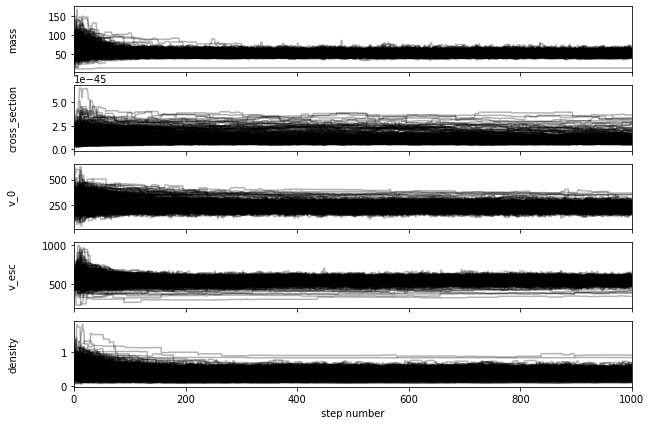

In [29]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['mass',
                                          'cross_section', 
                                                            'v_0',
                                                            'v_esc', 
                                                            'density']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(26500, 5)


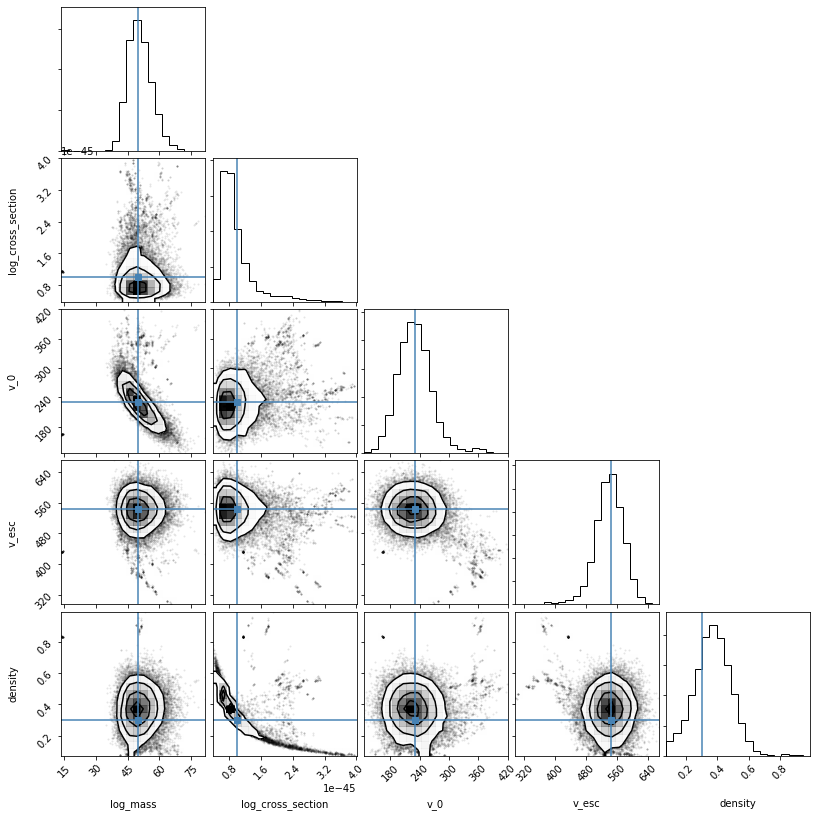

In [30]:
flat_samples = sampler.get_chain(discard=int(step*0.2), thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log_mass',
                                          'log_cross_section', 
                                                            'v_0',
                                                            'v_esc', 
                                                            'density'], 
                    truths=[50, 1e-45, 230, 544, 0.3]);

In [60]:
samples_emcee = sampler.chain[:, int(step*0.2):, :].reshape((-1, ndim))

In [63]:
np.shape(samples_emcee[4])

(5,)

In [72]:
for i in range(ndim):
    this_samp  = samples_emcee[:,i]
    print(f"{labels[i]}\nmean {np.mean(this_samp)}\tsig: {np.std(this_samp)}\n")

mass
mean 50.68734648863065	sig: 5.864856349962868

cross_section
mean 9.90248196263221e-46	sig: 4.983670047742629e-46

v_0
mean 230.4406550243484	sig: 36.569277115162976

v_esc
mean 538.701717554563	sig: 39.87606405249334

density
mean 0.36878270804431335	sig: 0.11717730069049828



In [31]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.357


### example of an errornous combination of parameters ###
Below, we have a combination of parameters that yields a spectrum with negative number of events in a bin, which is obviously **not** good. However, I work around it now by accepting that a little negative rate (-1<rate<0) is not such a great problem, let's just set it for 0 now.

In [70]:
dddm.eval_log_likelihood([7.89827908e+01, 4.55800899e-45, 3.78553277e+02, 1.56688729e+00,
 1.08146074e+00], 
                                                           ['log_mass',
                                                            'log_cross_section', 
                                                            'v_0',
                                                            'v_esc', 
                                                            'density'])

Serious error, finding negative rates. Presumably v_esc is too small


,counts,bin_centers,bin_left,bin_right
0,0.0,5.0,0.0,10.0
1,0.0,15.0,10.0,20.0
2,0.0,25.0,20.0,30.0
3,0.0,35.0,30.0,40.0
4,0.0,45.0,40.0,50.0
5,0.0,55.0,50.0,60.0
6,0.0,65.0,60.0,70.0
7,0.0,75.0,70.0,80.0
8,0.0,85.0,80.0,90.0
9,0.0,95.0,90.0,100.0
